# Simulation Experiment

In [2]:
import warnings
warnings.filterwarnings('ignore')
from IPython.utils.capture import capture_output
import os, sys
import numpy as np
import pandas as pd
from importlib import reload
sys.path.insert(0, os.path.abspath('../palin/python'))
import palin as pa
from palin.utils import utils
from palin.internal_noise import optimize
from palin.internal_noise import grid
from palin.kernels import classification_images

In [3]:
### rpy2
import sys
sys.executable
import rpy2
print(rpy2.__version__)
import os
os.environ['PATH'] = r'C:\Program Files\R\R-4.2.1\bin\x64'
os.environ['R_HOME'] = r'C:\Program Files\R\R-4.2.1' #path to your R installation
os.environ['R_USER'] = r'C:\Users\aynaz.adlzarrabi\Anaconda3\Lib\site-packages\rpy2' #path depends on where you installed Python. Mine is the Anaconda distribution
os.environ['R_LIBS_USER'] = r'C:\Program Files\R\R-4.2.1\library'
import rpy2.situation
for row in rpy2.situation.iter_info():
    print(row)
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
base = importr('base')
utils = importr('utils')
from pymer4.models import Lmer,Lm

3.5.6
rpy2 version:
3.5.6
Python version:
3.8.3 (tags/v3.8.3:6f8c832, May 13 2020, 22:37:02) [MSC v.1924 64 bit (AMD64)]
Looking for R's HOME:
    Environment variable R_HOME: C:\Program Files\R\R-4.2.1
    InstallPath in the registry: C:\Program Files\R\R-4.3.2
    Environment variable R_USER: C:\Users\aynaz.adlzarrabi\Anaconda3\Lib\site-packages\rpy2
    Environment variable R_LIBS_USER: C:\Program Files\R\R-4.2.1\library
R version:
    In the PATH: R version 4.2.1 (2022-06-23 ucrt) -- "Funny-Looking Kid"
    Loading R library from rpy2: OK
Additional directories to load R packages from:
None
C extension compilation:


## generate trials and responses

### with IN

In [14]:
import numpy as np
import pandas as pd

class SimulatedParticipant:
    def __init__(self, kernel):
        self.kernel = kernel

    def respond_to(self, stim_0, stim_1, criteria, internal_noise_std):
        activity_stim_0 = np.dot(stim_0, self.kernel)
        activity_stim_1 = np.dot(stim_1, self.kernel)
        internal_noise = np.random.normal(loc=0, scale=internal_noise_std)
        response = 0 if (activity_stim_0 - activity_stim_1 + internal_noise >= criteria) else 1
        return response
    
    
    
def createBPF(std_semitones, num_segments):
    BPFtime = np.linspace(0, 1, num_segments + 1)[:-1]
    BPFval = np.random.normal(loc=0, scale=std_semitones, size=num_segments)
    return range(num_segments), BPFtime, BPFval

def generate_random_kernel(size, low, high):
    return np.random.uniform(low, high, size)

def generate_random_criteria(low, high):
    return np.random.uniform(low, high)

def generate_random_std(low, high):
    return np.random.uniform(low, high)

def generate_trials(pitch_config, num_trials):
    trials = []
    stim_orders = []
    segments = []
    times = []
    values = []
    
    for trial in range(num_trials):
        for stim_order in range(2):
            stim_segments, stim_times, stim_values = createBPF(pitch_config['std_semitones'], pitch_config['num_segments'])
            trials += list(trial * np.ones(pitch_config['num_segments']))
            stim_orders += list(stim_order * np.ones(pitch_config['num_segments']))
            segments += list(stim_segments)
            times += list(stim_times)
            values += list(stim_values)
    
    return pd.DataFrame.from_dict({'trial': trials,
                                   'stim_order': stim_orders,
                                   'segment': segments,
                                   'time': times,
                                   'value': values})

kernel_size = 7
kernel = generate_random_kernel(kernel_size, -10, 10)

# Create a participant with the kernel
participant = SimulatedParticipant(kernel)

# Define the trial sets
trial_sets = [100, 500, 1000, 1500, 2000]

# Iterate over each set of trials
for num_trials in trial_sets:
    # Generate trial data
    pitch_config = {'std_semitones': 150, 'num_segments': 7}
    trials_df = generate_trials(pitch_config, num_trials)

    # Assign random criteria and internal noise for each trial
    trial_criteria = {trial: generate_random_criteria(-5, 5) for trial in range(num_trials)}
    trial_noise = {trial: generate_random_std(0, 2) for trial in range(num_trials)}

    trials_df['criteria'] = trials_df['trial'].map(trial_criteria)
    trials_df['internal_noise'] = trials_df['trial'].map(trial_noise)

    # Process the trials with the participant
    response_data = trials_df.groupby('trial').apply(
        lambda group: participant.respond_to(
            group[group['stim_order'] == 0]['value'].values, 
            group[group['stim_order'] == 1]['value'].values, 
            group['criteria'].iloc[0], 
            group['internal_noise'].iloc[0]
        )
    )

    # Add the responses to the trials_df
    trials_df['response'] = response_data.reindex(trials_df['trial']).reset_index(drop=True).values

    # The trials_df now contains the trials data along with the participant responses, criteria, and internal noise
    # You can process or analyze this data as needed
trials_df

trial  stim_order  segment      time       value  criteria  \
0         0.0         0.0        0  0.000000  -73.189439 -4.803133   
1         0.0         0.0        1  0.142857   30.346230 -4.803133   
2         0.0         0.0        2  0.285714   56.162948 -4.803133   
3         0.0         0.0        3  0.428571  176.756450 -4.803133   
4         0.0         0.0        4  0.571429  163.669336 -4.803133   
...       ...         ...      ...       ...         ...       ...   
27995  1999.0         1.0        2  0.285714   40.799213 -1.689789   
27996  1999.0         1.0        3  0.428571  -66.194117 -1.689789   
27997  1999.0         1.0        4  0.571429  -36.306636 -1.689789   
27998  1999.0         1.0        5  0.714286  189.352134 -1.689789   
27999  1999.0         1.0        6  0.857143   94.846553 -1.689789   

       internal_noise  response  
0            0.160233         0  
1            0.160233         0  
2            0.160233         0  
3            0.160233         0  
4            0.160233         0  
...               ...       ...  
27995        0.103479         0  
27996        0.103479         0  
27997        0.103479         0  
27998        0.103479         0  
27999        0.103479         0  

[28000 rows x 8 columns]

### without IN

In [8]:
import numpy as np
import pandas as pd

class SimulatedParticipant:
    def __init__(self, kernel):
        self.kernel = kernel

    def respond_to(self, stim_0, stim_1, criteria, internal_noise_std):
        activity_stim_0 = np.dot(stim_0, self.kernel)
        activity_stim_1 = np.dot(stim_1, self.kernel)
        internal_noise = np.random.normal(loc=0, scale=internal_noise_std)
        response = 0 if (activity_stim_0 - activity_stim_1 + internal_noise >= criteria) else 1
        return response
    
    
    
def createBPF(std_semitones, num_segments):
    BPFtime = np.linspace(0, 1, num_segments + 1)[:-1]
    BPFval = np.random.normal(loc=0, scale=std_semitones, size=num_segments)
    return range(num_segments), BPFtime, BPFval

def generate_random_kernel(size, low, high):
    return np.random.uniform(low, high, size)

def generate_random_criteria(low, high):
    return np.random.uniform(low, high)

def generate_random_std(low, high):
    return np.random.uniform(low, high)

def generate_trials(pitch_config, num_trials):
    trials = []
    stim_orders = []
    segments = []
    times = []
    values = []
    
    for trial in range(num_trials):
        for stim_order in range(2):
            stim_segments, stim_times, stim_values = createBPF(pitch_config['std_semitones'], pitch_config['num_segments'])
            trials += list(trial * np.ones(pitch_config['num_segments']))
            stim_orders += list(stim_order * np.ones(pitch_config['num_segments']))
            segments += list(stim_segments)
            times += list(stim_times)
            values += list(stim_values)
    
    return pd.DataFrame.from_dict({'trial': trials,
                                   'stim_order': stim_orders,
                                   'segment': segments,
                                   'time': times,
                                   'value': values})
kernel_size = 7
kernel = generate_random_kernel(kernel_size, -10, 10)

# Create a participant with the kernel
participant = SimulatedParticipant(kernel)

trial_sets = [100, 500, 1000, 1500, 2000]

# Initialize a list to store all trials data
all_trials_data = []

# Iterate over each set of trials
for num_trials in trial_sets:
    # Generate trial data
    pitch_config = {'std_semitones': 150, 'num_segments': 7}
    trials_df = generate_trials(pitch_config, num_trials)

    # Assign random criteria and internal noise for each trial
    trial_criteria = {trial: generate_random_criteria(0, 0) for trial in range(num_trials)}
    trial_noise = {trial: generate_random_std(0, 0) for trial in range(num_trials)}

    trials_df['criteria'] = trials_df['trial'].map(trial_criteria)
    trials_df['internal_noise'] = trials_df['trial'].map(trial_noise)
    
    # Add a new column for the trial set size
    trials_df['trial_size'] = num_trials

    # Process the trials with the participant
    response_data = trials_df.groupby('trial').apply(
        lambda group: participant.respond_to(
            group[group['stim_order'] == 0]['value'].values, 
            group[group['stim_order'] == 1]['value'].values, 
            group['criteria'].iloc[0], 
            group['internal_noise'].iloc[0]
        )
    )

    # Add the responses to the trials_df
    trials_df['response'] = response_data.reindex(trials_df['trial']).reset_index(drop=True).values

    # Add the DataFrame to the list
    all_trials_data.append(trials_df)


# Concatenate all the DataFrames in the list into one DataFrame
all_trials_df = pd.concat(all_trials_data, ignore_index=True)

all_trials_df

trial  stim_order  segment      time       value  criteria  \
0         0.0         0.0        0  0.000000  -65.127741       0.0   
1         0.0         0.0        1  0.142857  162.692636       0.0   
2         0.0         0.0        2  0.285714   65.141214       0.0   
3         0.0         0.0        3  0.428571  292.400323       0.0   
4         0.0         0.0        4  0.571429 -197.814992       0.0   
...       ...         ...      ...       ...         ...       ...   
71395  1999.0         1.0        2  0.285714   49.099572       0.0   
71396  1999.0         1.0        3  0.428571   -0.194106       0.0   
71397  1999.0         1.0        4  0.571429 -203.163742       0.0   
71398  1999.0         1.0        5  0.714286 -248.843162       0.0   
71399  1999.0         1.0        6  0.857143  -93.717085       0.0   

       internal_noise  trial_size  response  
0                 0.0         100         0  
1                 0.0         100         0  
2                 0.0         100         0  
3                 0.0         100         0  
4                 0.0         100         0  
...               ...         ...       ...  
71395             0.0        2000         0  
71396             0.0        2000         0  
71397             0.0        2000         0  
71398             0.0        2000         0  
71399             0.0        2000         0  

[71400 rows x 9 columns]

In [15]:
# Number of participants
num_participants = 15

# Size of the kernel
kernel_size = 7

# Range for the random kernel generation
kernel_low, kernel_high = -10, 10

# Trial sets for the simulation
trial_sets = [100, 500, 1000, 1500, 2000]

# Define the pitch configuration once, if it's the same for all participants
pitch_config = {'std_semitones': 150, 'num_segments': kernel_size}

# This will store the DataFrame for each participant and each trial set
all_participant_data = []
trial_ids=['trial_set_size', 'internal_noise', 'criteria','participant_num']
kernel = generate_random_kernel(kernel_size, kernel_low, kernel_high)

# Loop over the number of participants
for participant_num in range(num_participants):
    # Create a participant instance
    participant = SimulatedParticipant(kernel)
    
    # For each trial set size
    for num_trials in trial_sets:
        # Generate trial data for the participant
        trials_df = generate_trials(pitch_config, num_trials)
        
        # Assign random criteria and internal noise for each trial
        trials_df['criteria'] = generate_random_criteria(0, 0)  # Adjust the range as needed
        trials_df['internal_noise'] = generate_random_std(0, 0)  # Adjust the range as needed
        
        # Simulate the participant's response to each trial
        response_data = trials_df.groupby('trial').apply(
        lambda group: participant.respond_to(
            group[group['stim_order'] == 0]['value'].values, 
            group[group['stim_order'] == 1]['value'].values, 
            group['criteria'].iloc[0], 
            group['internal_noise'].iloc[0]
        )
    )
        
        # Add the participant number and trial set size to the DataFrame
        trials_df['participant_num'] = participant_num
        trials_df['trial_set_size'] = num_trials
        trials_df['response'] = response_data.reindex(trials_df['trial']).reset_index(drop=True).values
        
        # Append the participant's trial data to the list
        all_participant_data.append(trials_df)

# Combine all participant data into a single DataFrame
all_data_df = pd.concat(all_participant_data, ignore_index=True)

In [27]:
# Number of participants
num_participants = 15

# Size of the kernel
kernel_size = 7

# Range for the random kernel generation
kernel_low, kernel_high = -10, 10

# Trial sets for the simulation
trial_sets = [100, 500, 1000, 1500, 2000]

# Define the pitch configuration once, if it's the same for all participants
pitch_config = {'std_semitones': 150, 'num_segments': kernel_size}

# Generate a unique kernel for all participants
kernel = generate_random_kernel(kernel_size, kernel_low, kernel_high)

# This will store the DataFrame for each participant and each trial set
all_participant_data = []

# Loop over the number of participants
for participant_num in range(num_participants):
    # Create a participant instance with the common kernel
    participant = SimulatedParticipant(kernel)
    
    # For each trial set size
    for num_trials in trial_sets:
        # Generate trial data for the participant
        trials_df = generate_trials(pitch_config, num_trials)
        
        # Assign random criteria and internal noise for each trial
        trials_df['criteria'] = generate_random_criteria(0, 0)  # Adjust the range as needed
        trials_df['internal_noise'] = generate_random_std(0, 0)  # Adjust the range as needed
        
        # Simulate the participant's response to each trial
        response_data = trials_df.groupby('trial').apply(
            lambda group: participant.respond_to(
                group[group['stim_order'] == 0]['value'].values, 
                group[group['stim_order'] == 1]['value'].values, 
                group['criteria'].iloc[0], 
                group['internal_noise'].iloc[0]
            )
        )
        
        # Add the participant number and trial set size to the DataFrame
        trials_df['participant_num'] = participant_num
        trials_df['trial_set_size'] = num_trials
        trials_df['response'] = response_data.reindex(trials_df['trial']).reset_index(drop=True).values
        
        # Append the participant's trial data to the list
        all_participant_data.append(trials_df)

# Combine all participant data into a single DataFrame
all_data_df = pd.concat(all_participant_data, ignore_index=True)

# Compute the kernels
trial_ids = ['trial_set_size', 'internal_noise', 'criteria', 'participant_num']
kernels = classification_images.compute_kernel(all_data_df, trial_ids, 'segment', 'response', 'value')

# Display the kernels
kernels

trial_set_size  internal_noise  criteria  participant_num  segment  \
0               100             0.0       0.0                0        0   
1               100             0.0       0.0                0        1   
2               100             0.0       0.0                0        2   
3               100             0.0       0.0                0        3   
4               100             0.0       0.0                0        4   
..              ...             ...       ...              ...      ...   
520            2000             0.0       0.0               14        2   
521            2000             0.0       0.0               14        3   
522            2000             0.0       0.0               14        4   
523            2000             0.0       0.0               14        5   
524            2000             0.0       0.0               14        6   

     kernel_value  norm_value  
0       36.043066    1.522524  
1      -37.401150   -1.579892  
2        6.059858    0.255979  
3        2.600572    0.109853  
4      -32.660913   -1.379656  
..            ...         ...  
520     -1.371495   -0.256655  
521      5.933260    1.110324  
522      2.510155    0.469739  
523     -9.820406   -1.837747  
524      4.663970    0.872795  

[525 rows x 7 columns]

## CI kernel computaion with palin

In [51]:
class SimulatedParticipant:
    def __init__(self, kernel):
        self.kernel = kernel

    def respond_to(self, stim_0, stim_1, criteria, internal_noise_std):
        activity_stim_0 = np.dot(stim_0, self.kernel)
        activity_stim_1 = np.dot(stim_1, self.kernel)
        internal_noise = np.random.normal(loc=0, scale=internal_noise_std)
        response = 0 if (activity_stim_0 - activity_stim_1 + internal_noise >= criteria) else 1
        return response
    
def createBPF(std_semitones, num_segments):
    BPFtime = np.linspace(0, 1, num_segments + 1)[:-1]
    BPFval = np.random.normal(loc=0, scale=std_semitones, size=num_segments)
    return range(num_segments), BPFtime, BPFval

def generate_random_kernel(size, low, high):
    return np.random.uniform(low, high, size)

def generate_random_criteria(low, high):
    return np.random.uniform(low, high)

def generate_random_std(low, high):
    return np.random.uniform(low, high)

def generate_trials(pitch_config, num_trials):
    trials = []
    stim_orders = []
    segments = []
    times = []
    values = []
    
    for trial in range(num_trials):
        for stim_order in range(2):
            stim_segments, stim_times, stim_values = createBPF(pitch_config['std_semitones'], pitch_config['num_segments'])
            trials += list(trial * np.ones(pitch_config['num_segments']))
            stim_orders += list(stim_order * np.ones(pitch_config['num_segments']))
            segments += list(stim_segments)
            times += list(stim_times)
            values += list(stim_values)
    
    return pd.DataFrame.from_dict({'trial': trials,
                                   'stim_order': stim_orders,
                                   'segment': segments,
                                   'time': times,
                                   'value': values})
num_participants = 15

# Size of the kernel
kernel_size = 7

# Range for the random kernel generation
kernel_low, kernel_high = -10, 10

# Trial sets for the simulation
trial_sets = [100, 500, 1000, 1500, 2000]

# Define the pitch configuration once, if it's the same for all participants
pitch_config = {'std_semitones': 150, 'num_segments': kernel_size}

# Generate a unique kernel for all participants
kernel = generate_random_kernel(kernel_size, kernel_low, kernel_high)

# This will store the kernels for each participant
all_kernels = []

# Loop over the number of participants
for participant_num in range(num_participants):
    # Create a participant instance with the common kernel
    participant = SimulatedParticipant(kernel)
    
    # Store the participant's data
    participant_data = []

    # For each trial set size
    for num_trials in trial_sets:
        # Generate trial data for the participant
        trials_df = generate_trials(pitch_config, num_trials)
        
        # Assign random criteria and internal noise for each trial
        trials_df['criteria'] = generate_random_criteria(0, 0)  # Adjust the range as needed
        trials_df['internal_noise'] = generate_random_std(0, 0)  # Adjust the range as needed
        
        # Simulate the participant's response to each trial
        response_data = trials_df.groupby('trial').apply(
            lambda group: participant.respond_to(
                group[group['stim_order'] == 0]['value'].values, 
                group[group['stim_order'] == 1]['value'].values, 
                group['criteria'].iloc[0], 
                group['internal_noise'].iloc[0]
            )
        )
        
        # Add the participant number and trial set size to the DataFrame
        trials_df['participant_num'] = participant_num
        trials_df['trial_set_size'] = num_trials
        trials_df['response'] = response_data.reindex(trials_df['trial']).reset_index(drop=True).values
        
        # Append the participant's trial data
        participant_data.append(trials_df)

    # Combine this participant's data into a single DataFrame
    participant_data_df = pd.concat(participant_data, ignore_index=True)

    # Compute the kernel for this participant
    trial_ids = ['trial_set_size', 'internal_noise', 'criteria', 'participant_num']
    participant_kernel = classification_images.compute_kernel(participant_data_df, trial_ids, 'segment', 'response', 'value')

    # Append this participant's kernel to the list
    all_kernels.append(participant_kernel)

In [52]:
combined_kernels_df = pd.concat(all_kernels, ignore_index=True)
combined_kernels_df

trial_set_size  internal_noise  criteria  participant_num  segment  \
0               100             0.0       0.0                0        0   
1               100             0.0       0.0                0        1   
2               100             0.0       0.0                0        2   
3               100             0.0       0.0                0        3   
4               100             0.0       0.0                0        4   
..              ...             ...       ...              ...      ...   
520            2000             0.0       0.0               14        2   
521            2000             0.0       0.0               14        3   
522            2000             0.0       0.0               14        4   
523            2000             0.0       0.0               14        5   
524            2000             0.0       0.0               14        6   

     kernel_value  norm_value  
0        0.489169    0.040638  
1       -4.064941   -0.337696  
2      -19.783091   -1.643484  
3       -5.969865   -0.495948  
4      -15.392844   -1.278763  
..            ...         ...  
520      2.672454    0.745978  
521     -7.357013   -2.053606  
522     -4.166546   -1.163032  
523     -1.199803   -0.334908  
524      0.081694    0.022804  

[525 rows x 7 columns]

## Simulate participant w/ CI kernel and IN 0 (graphs)

In [92]:
class SimulatedParticipant:
    def __init__(self, kernel):
        self.kernel = kernel

    def respond_to(self, stim_0, stim_1, criteria, internal_noise_std):
        activity_stim_0 = np.dot(stim_0, self.kernel)
        activity_stim_1 = np.dot(stim_1, self.kernel)
        internal_noise = np.random.normal(loc=0, scale=internal_noise_std)
        response = 0 if (activity_stim_0 - activity_stim_1 + internal_noise >= criteria) else 1
        return response
    
def createBPF(std_semitones, num_segments):
    BPFtime = np.linspace(0, 1, num_segments + 1)[:-1]
    BPFval = np.random.normal(loc=0, scale=std_semitones, size=num_segments)
    return range(num_segments), BPFtime, BPFval

def generate_random_kernel(size, low, high):
    return np.random.uniform(low, high, size)

def generate_random_criteria(low, high):
    return np.random.uniform(low, high)

def generate_random_std(low, high):
    return np.random.uniform(low, high)

def generate_trials(pitch_config, num_trials):
    trials = []
    stim_orders = []
    segments = []
    times = []
    values = []
    
    for trial in range(num_trials):
        for stim_order in range(2):
            stim_segments, stim_times, stim_values = createBPF(pitch_config['std_semitones'], pitch_config['num_segments'])
            trials += list(trial * np.ones(pitch_config['num_segments']))
            stim_orders += list(stim_order * np.ones(pitch_config['num_segments']))
            segments += list(stim_segments)
            times += list(stim_times)
            values += list(stim_values)
    
    return pd.DataFrame.from_dict({'trial': trials,
                                   'stim_order': stim_orders,
                                   'segment': segments,
                                   'time': times,
                                   'value': values})
num_participants = 15

# Size of the kernel
kernel_size = 7

# Range for the random kernel generation
kernel_low, kernel_high = -10, 10

# Trial sets for the simulation
trial_sets = [100, 500, 1000, 1500, 2000,3000,5000]

# Define the pitch configuration once, if it's the same for all participants
pitch_config = {'std_semitones': 150, 'num_segments': kernel_size}
CRITERIA_RANGE = (0, 0)  # Example range for criteria
NOISE_STD_RANGE = (0, 0)  
# Generate a unique kernel for all participants
kernel = generate_random_kernel(kernel_size, kernel_low, kernel_high)
def simulate_participants(num_participants, kernel, trial_sets, pitch_config, criteria_range, noise_std_range, trial_ids):
    all_kernels = []

    for participant_num in range(num_participants):
        participant = SimulatedParticipant(kernel)
        participant_data = []

        for num_trials in trial_sets:
            trials_df = generate_trials(pitch_config, num_trials)
            trials_df['criteria'] = generate_random_criteria(*criteria_range)
            trials_df['internal_noise'] = generate_random_std(*noise_std_range)

            response_data = trials_df.groupby('trial').apply(
                lambda group: participant.respond_to(
                    group[group['stim_order'] == 0]['value'].values, 
                    group[group['stim_order'] == 1]['value'].values, 
                    group['criteria'].iloc[0], 
                    group['internal_noise'].iloc[0]
                )
            )

            trials_df['participant_num'] = participant_num
            trials_df['trial_set_size'] = num_trials
            trials_df['response'] = response_data.reindex(trials_df['trial']).reset_index(drop=True).values
            participant_data.append(trials_df)

        participant_data_df = pd.concat(participant_data, ignore_index=True)
        participant_kernel = classification_images.compute_kernel(participant_data_df, trial_ids, 'segment', 'response', 'value')
        all_kernels.append(participant_kernel)

    return all_kernels
trial_ids = ['trial_set_size', 'internal_noise', 'criteria', 'participant_num']
all_kernels = simulate_participants(num_participants, kernel, trial_sets, pitch_config, CRITERIA_RANGE, NOISE_STD_RANGE, trial_ids)

## Graphs 

### random kernel visualization

In [100]:
particpant_kernel

pitch  segment
0 -1.490067        0
1 -4.256152        1
2 -7.809246        2
3 -7.801208        3
4 -8.811574        4
5 -8.884370        5
6  0.935217        6

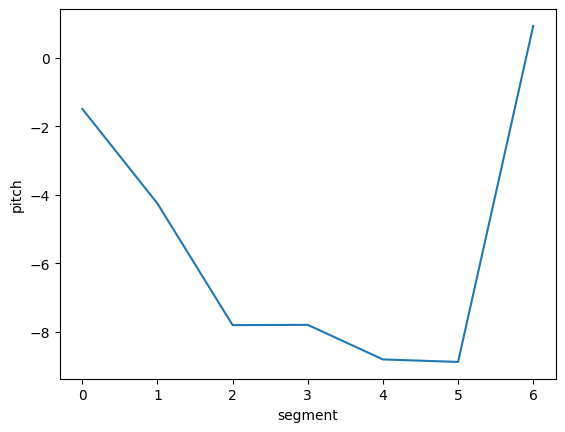

In [93]:
particpant_kernel=pd.DataFrame(kernel,columns=['pitch'])
particpant_kernel['segment']= range(7)
particpant_kernel_df = particpant_kernel['pitch'].values
sns.lineplot(x="segment", y="pitch",
             data=particpant_kernel) 
plt.show()

### Kernel value Evolution

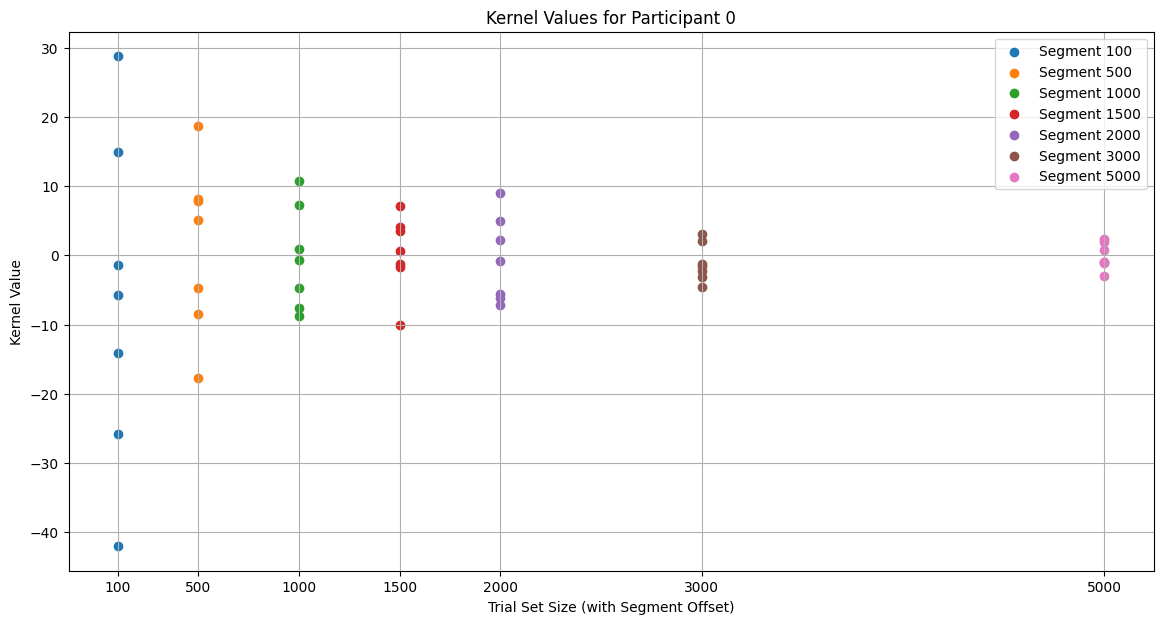

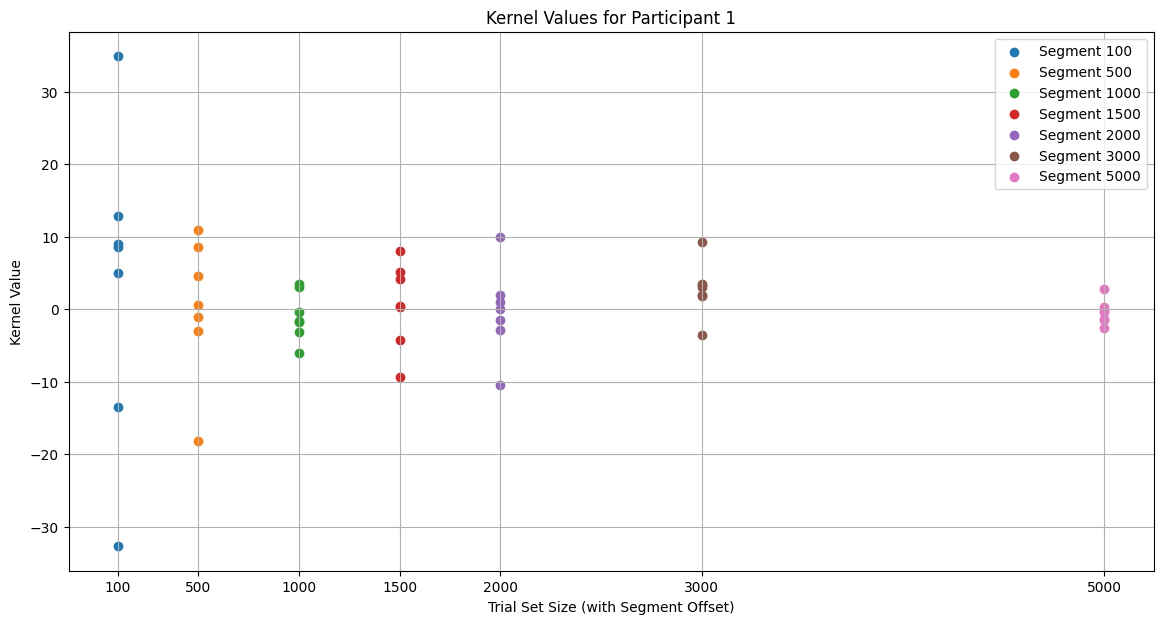

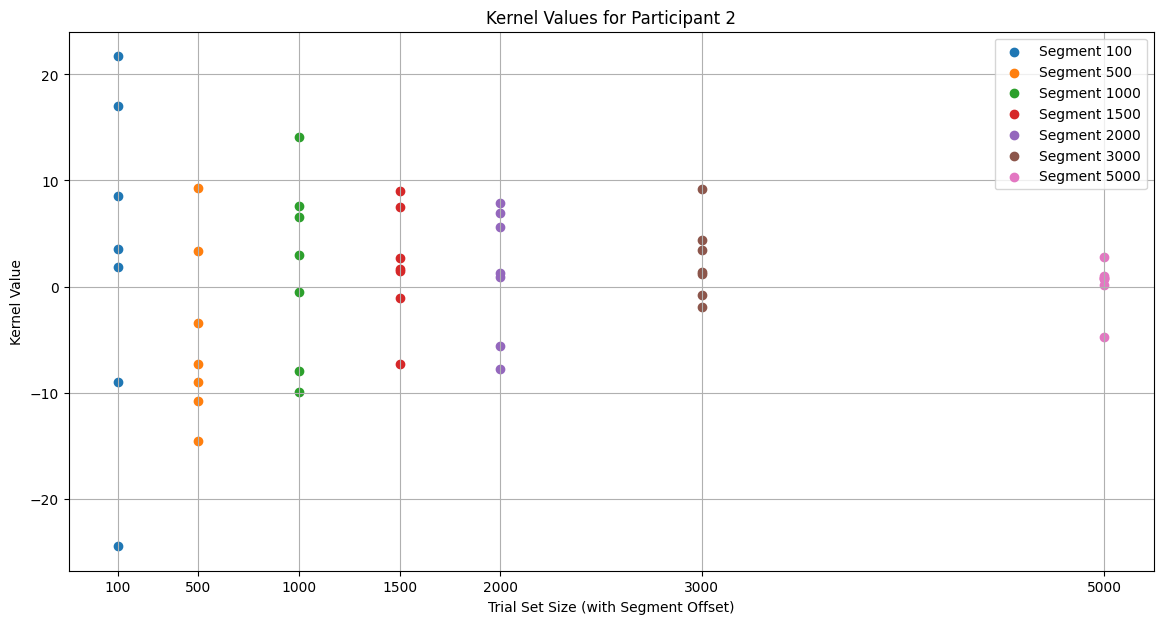

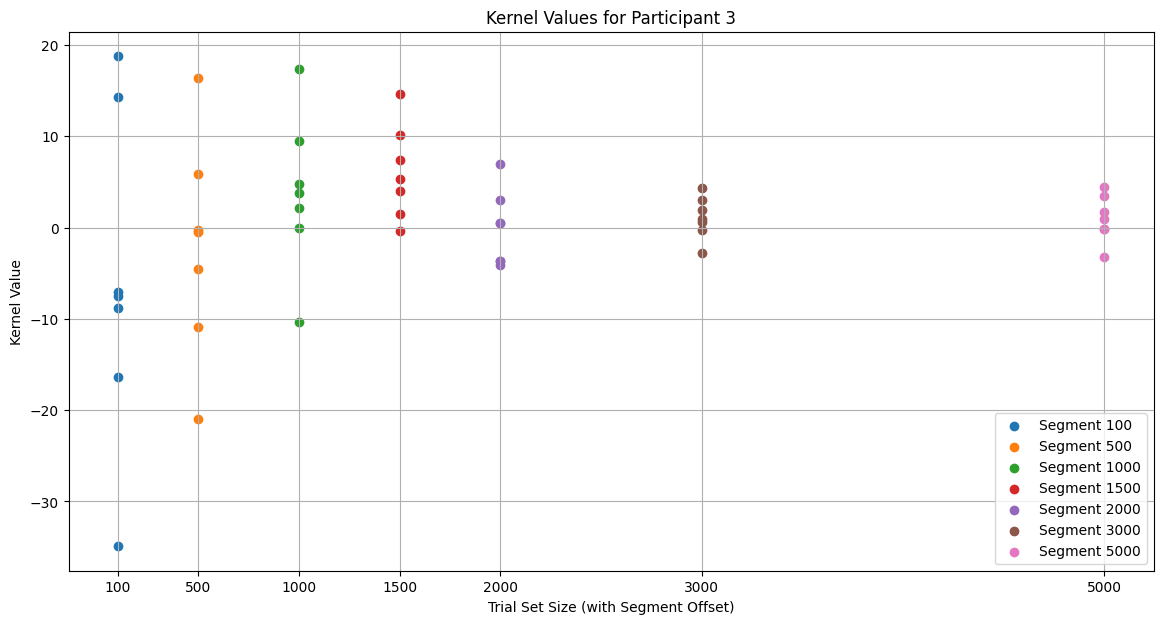

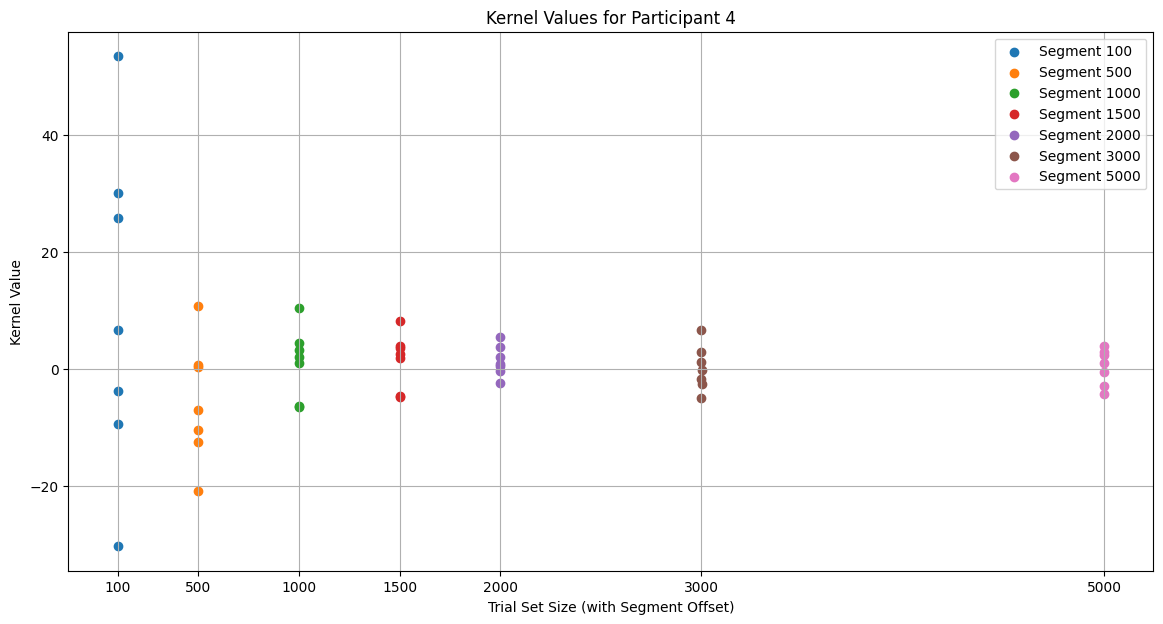

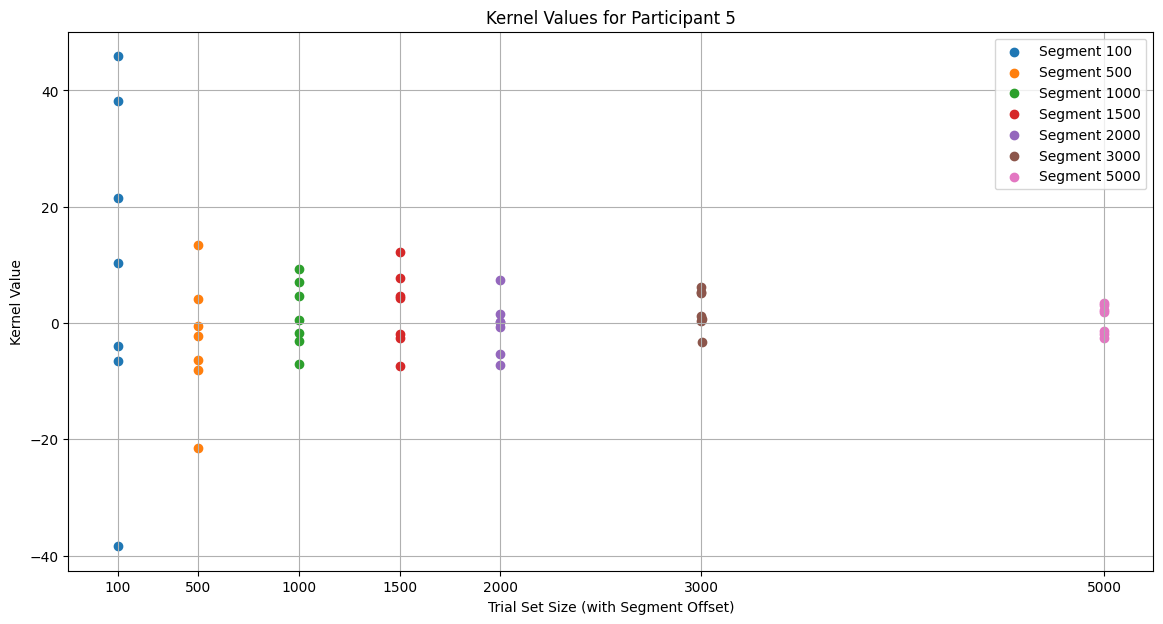

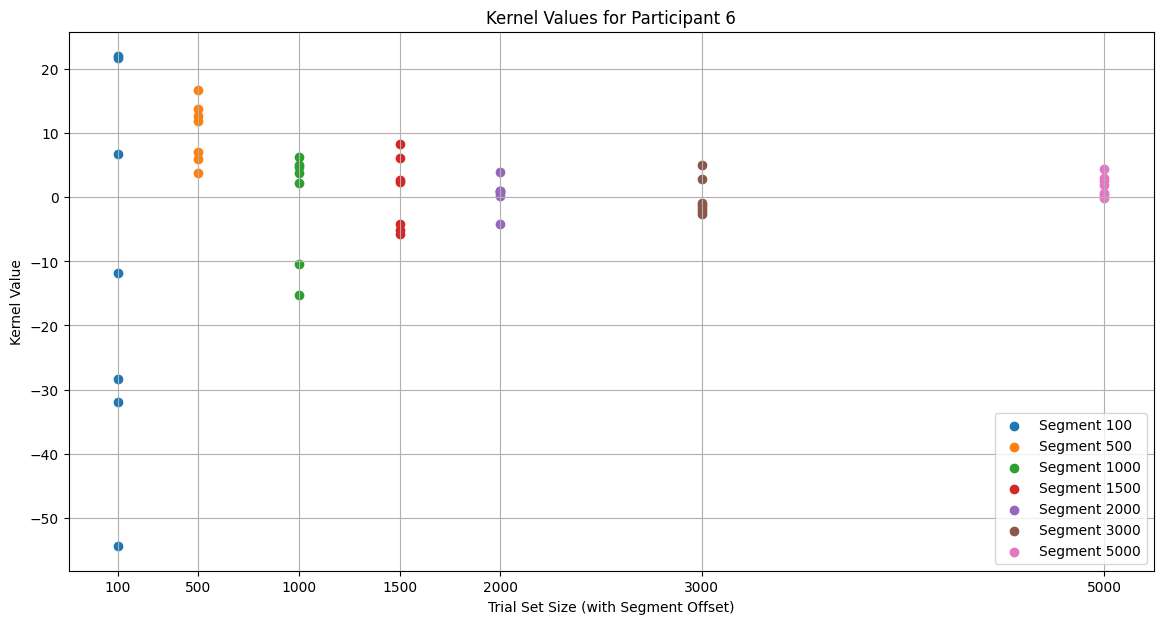

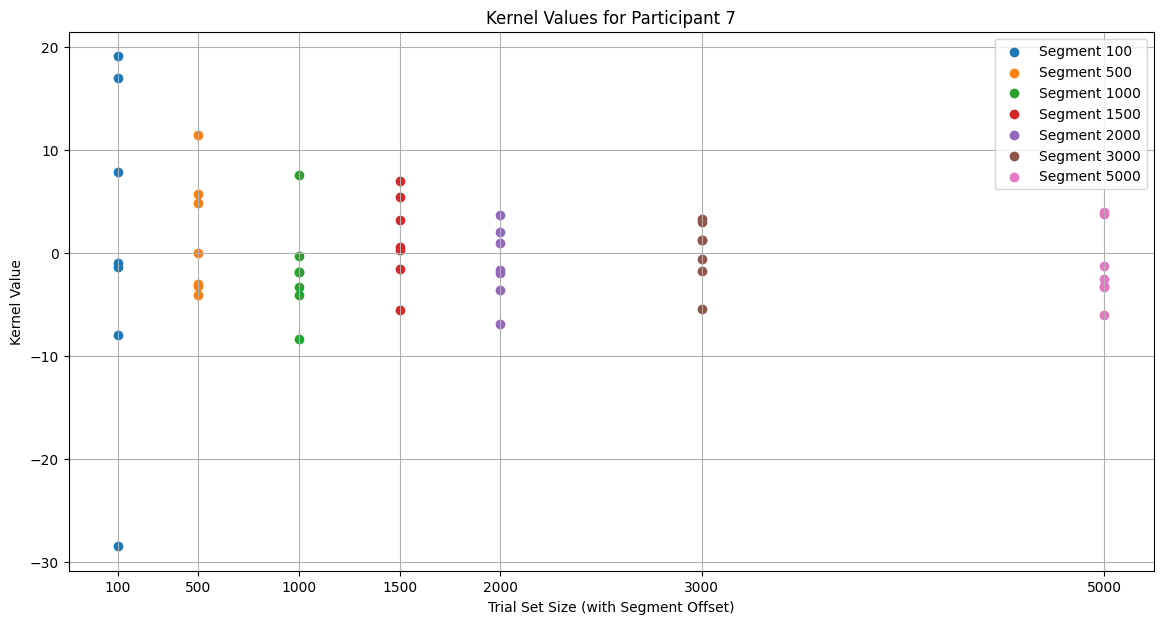

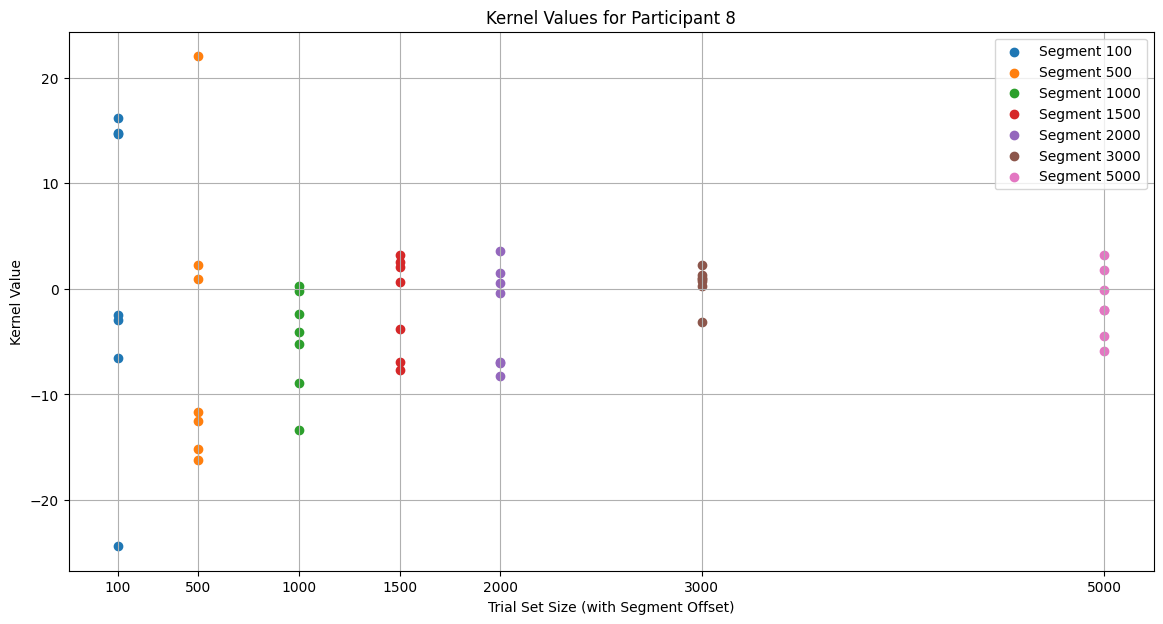

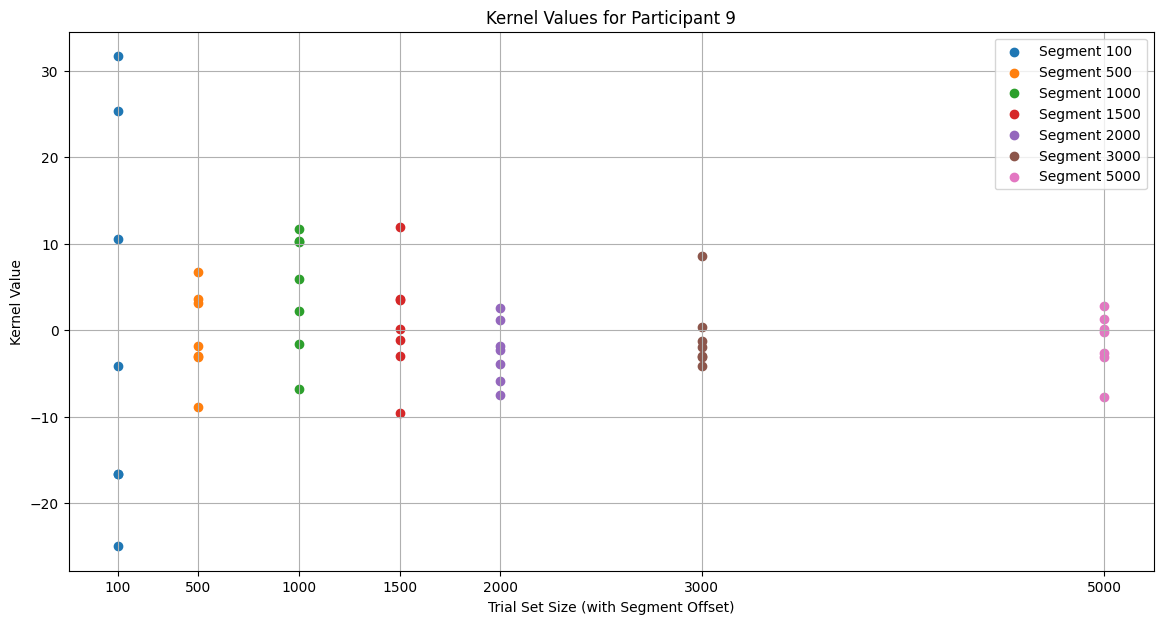

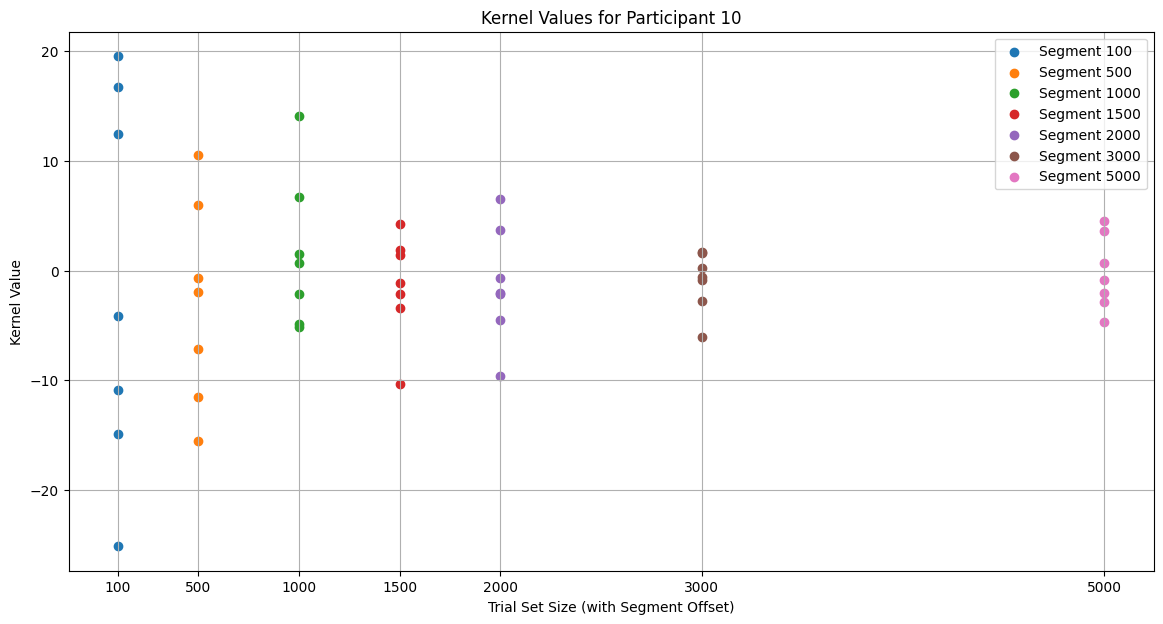

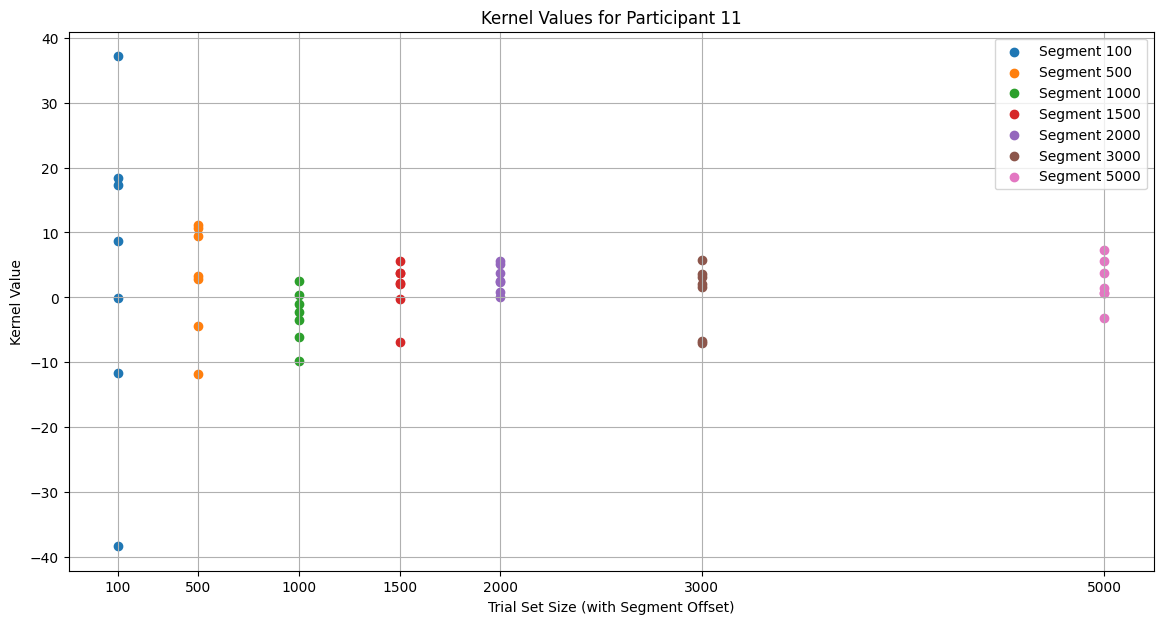

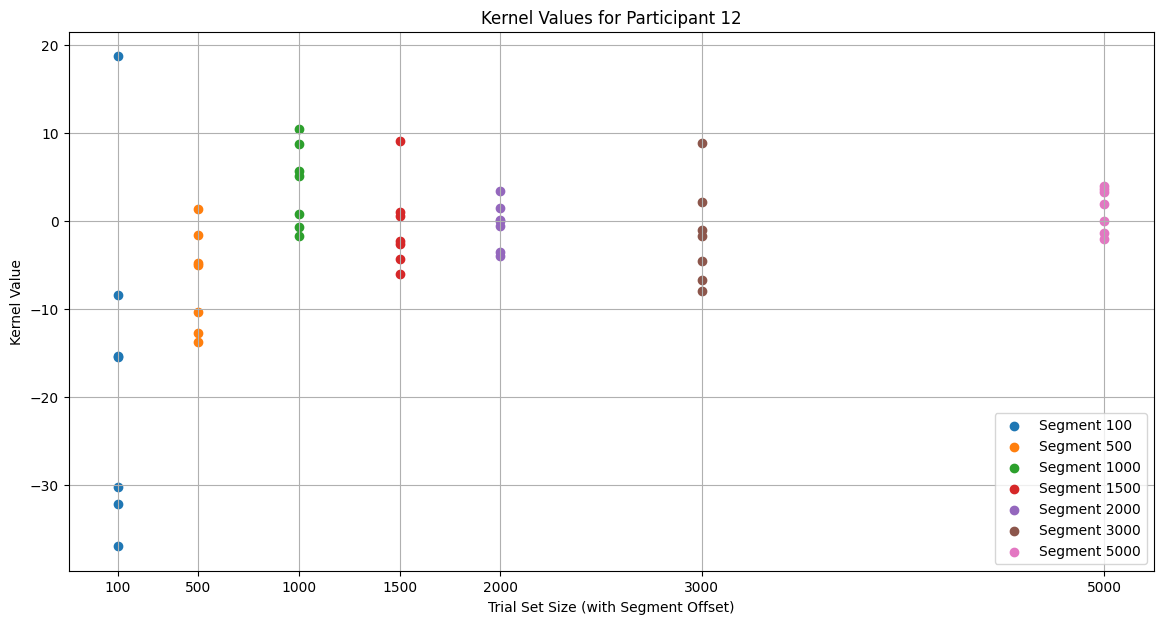

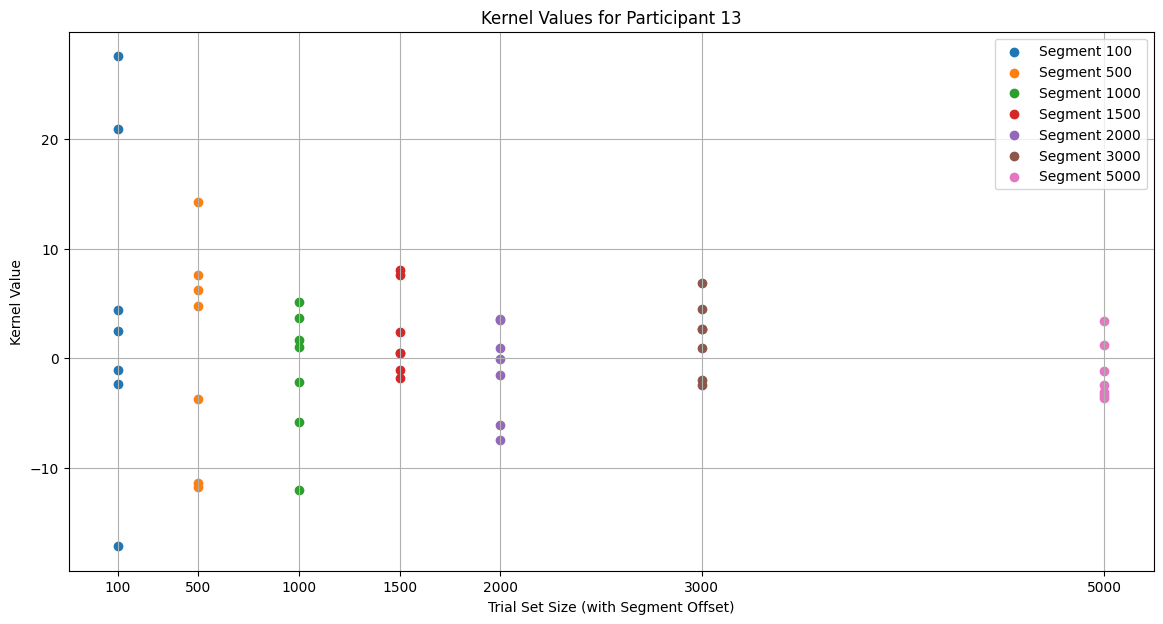

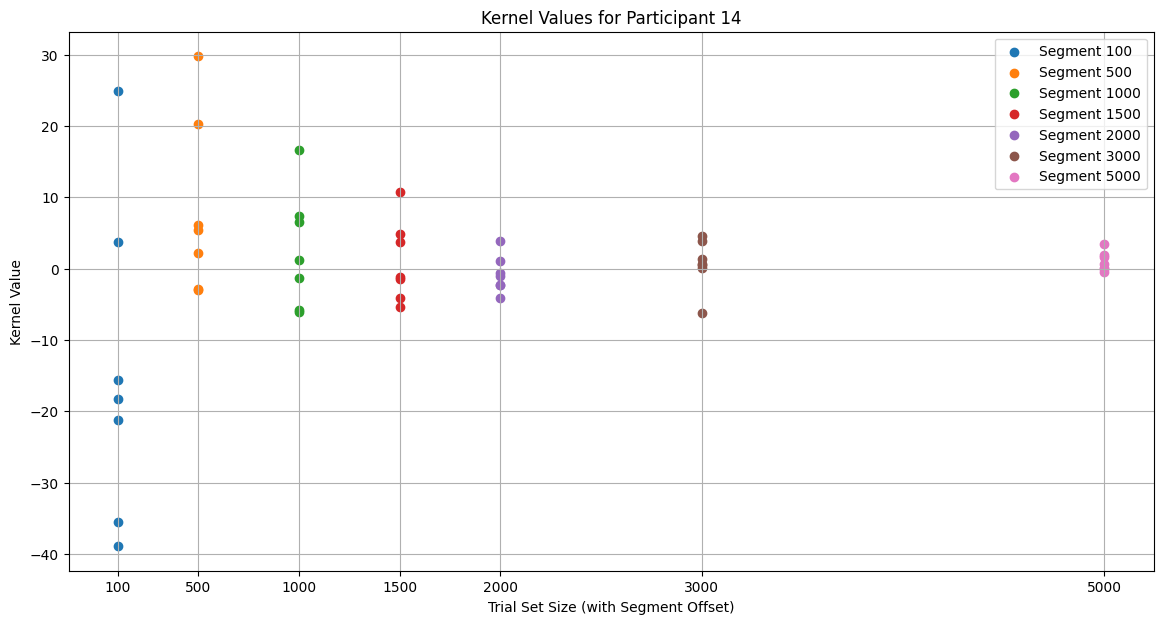

In [95]:
import matplotlib.pyplot as plt

# Assuming all_kernels is a list of DataFrames, where each DataFrame represents a participant's data
for i, participant_df in enumerate(all_kernels):
    # Create a figure for each participant
    plt.figure(figsize=(14, 7))
    
    # Plot kernel values for each segment within each trial set size
    # Here, we're assuming that 'segment' can be treated as a categorical variable
    for trial_set in participant_df['trial_set_size'].unique():
        trial_data = participant_df[participant_df['trial_set_size'] == trial_set]
        # Apply an offset to each segment to separate them visually
        offset = (trial_data['segment'] - trial_data['segment'].min()) * 0.1
        plt.scatter(trial_data['trial_set_size'] + offset, trial_data['kernel_value'], label=f'Segment {trial_set}')
    
    plt.title(f'Kernel Values for Participant {i}')
    plt.xlabel('Trial Set Size (with Segment Offset)')
    plt.xticks([100, 500, 1000, 1500, 2000,3000,5000])
    plt.ylabel('Kernel Value')
    plt.legend()
    plt.grid(True)
    plt.show()


In [99]:
combined_kernels_df = pd.concat(all_kernels, ignore_index=True)
combined_kernels_df.head(10)

trial_set_size  internal_noise  criteria  participant_num  segment  \
0             100             0.0       0.0                0        0   
1             100             0.0       0.0                0        1   
2             100             0.0       0.0                0        2   
3             100             0.0       0.0                0        3   
4             100             0.0       0.0                0        4   
5             100             0.0       0.0                0        5   
6             100             0.0       0.0                0        6   
7             500             0.0       0.0                0        0   
8             500             0.0       0.0                0        1   
9             500             0.0       0.0                0        2   

   kernel_value  norm_value  
0     28.757545    1.247853  
1     14.926678    0.647702  
2    -14.137746   -0.613468  
3    -42.019586   -1.823323  
4    -25.841695   -1.121328  
5     -1.331447   -0.057774  
6     -5.728135   -0.248556  
7     18.631693    1.638447  
8      8.062911    0.709042  
9      5.153749    0.453214

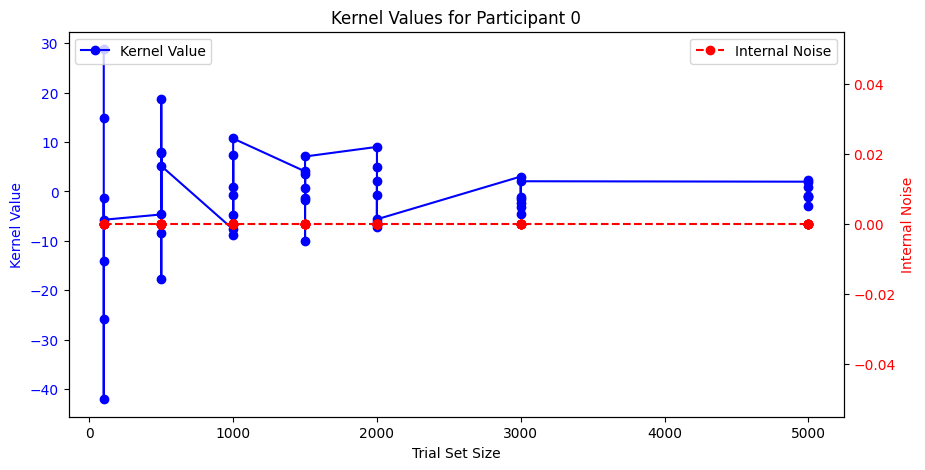

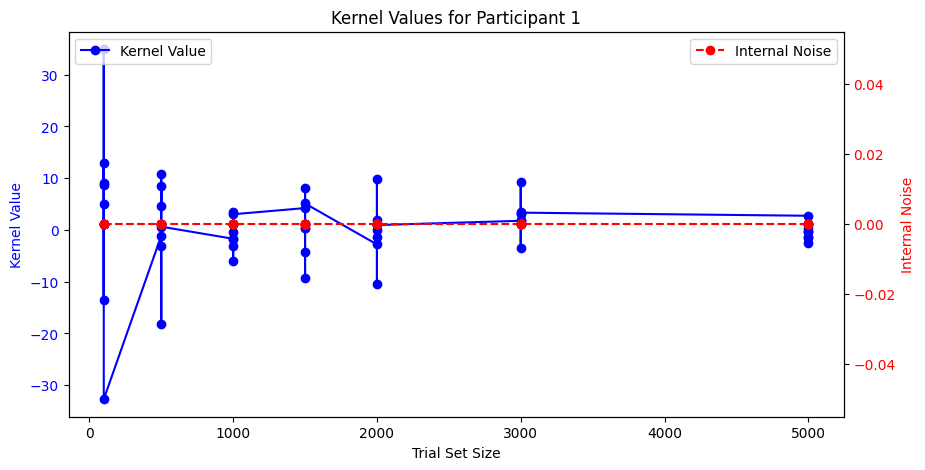

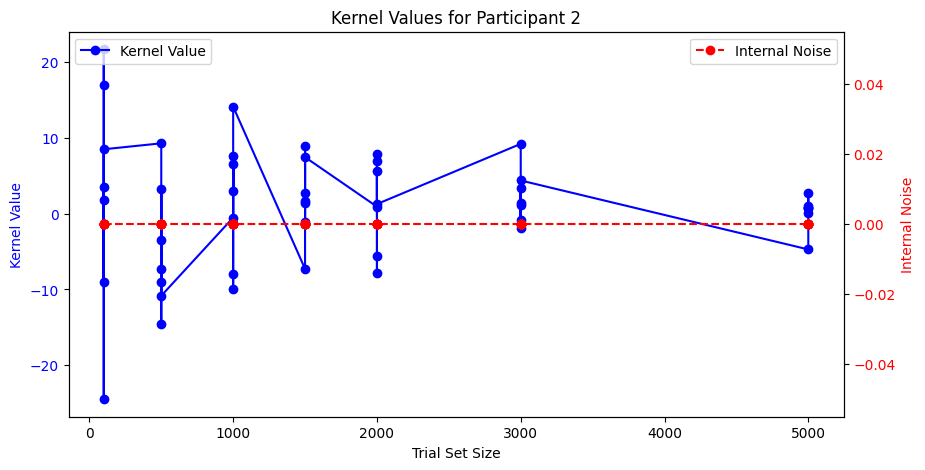

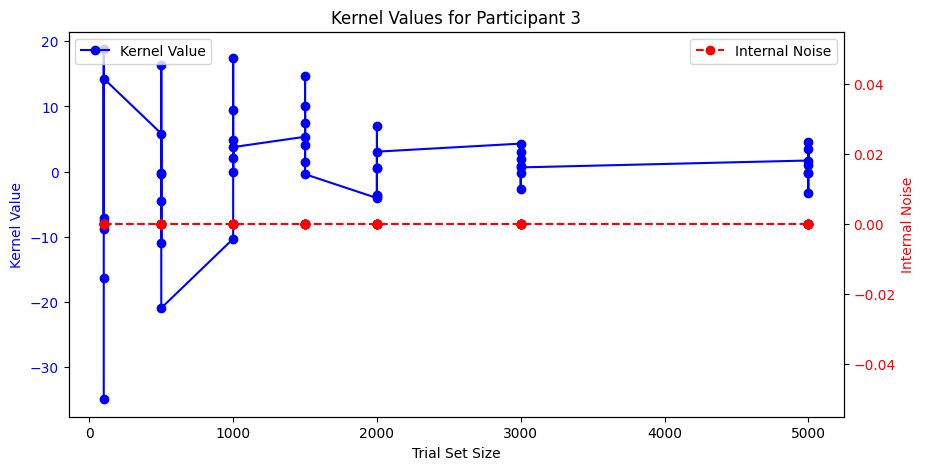

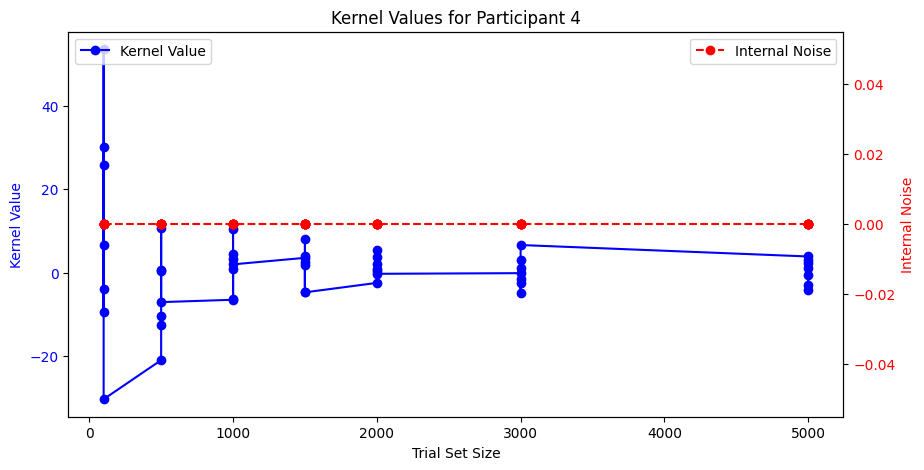

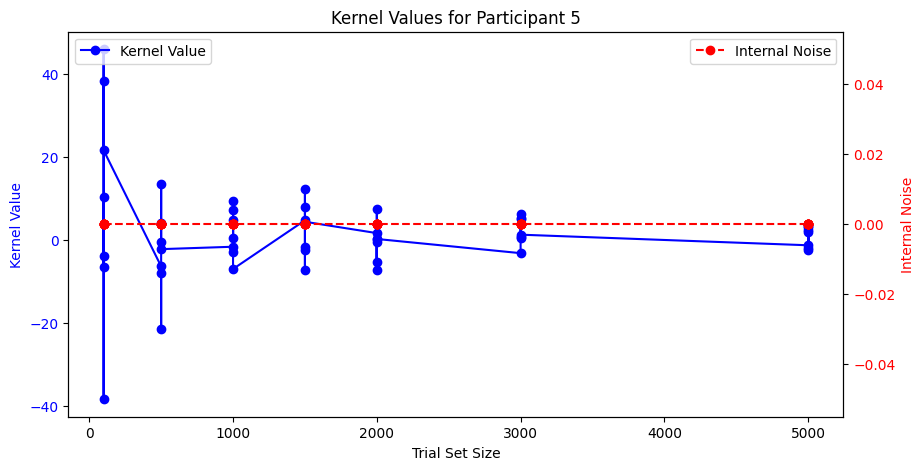

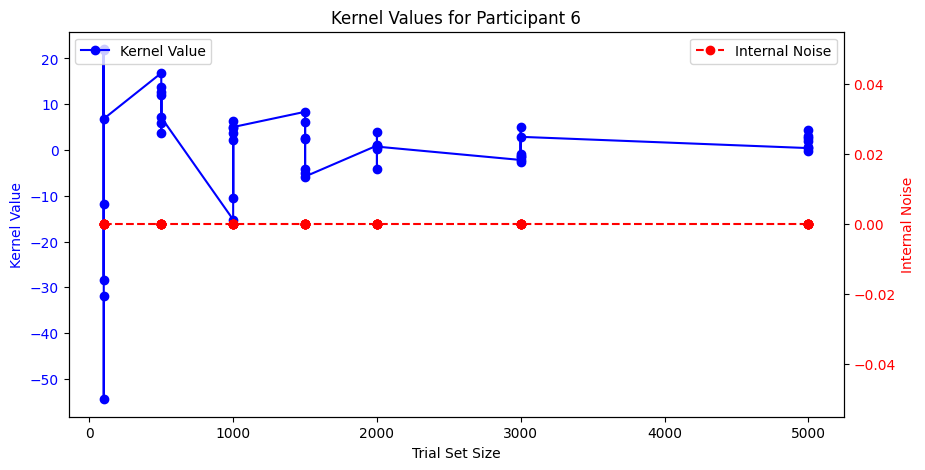

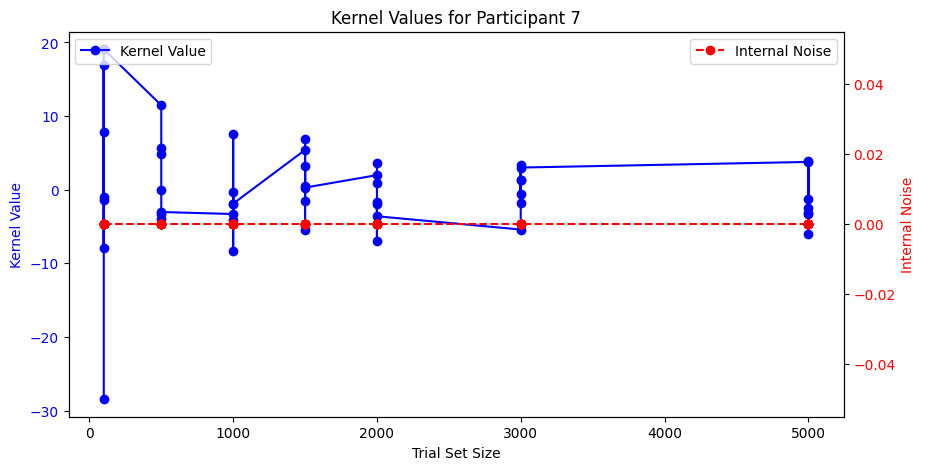

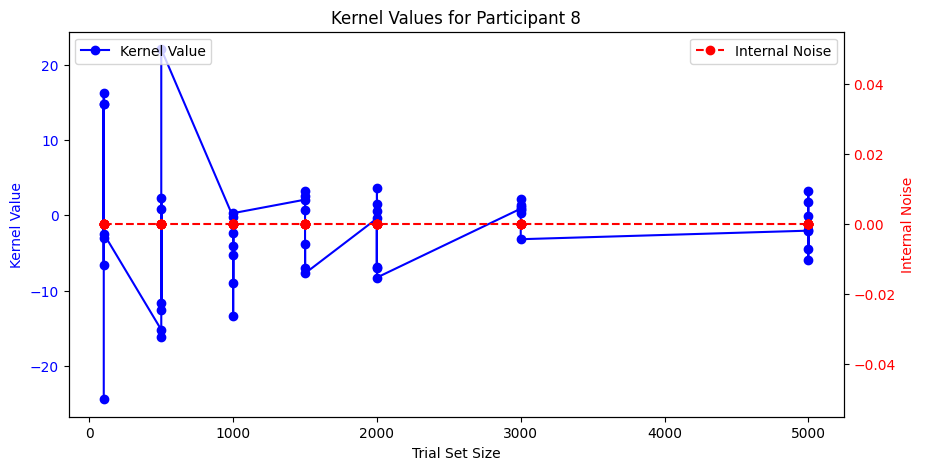

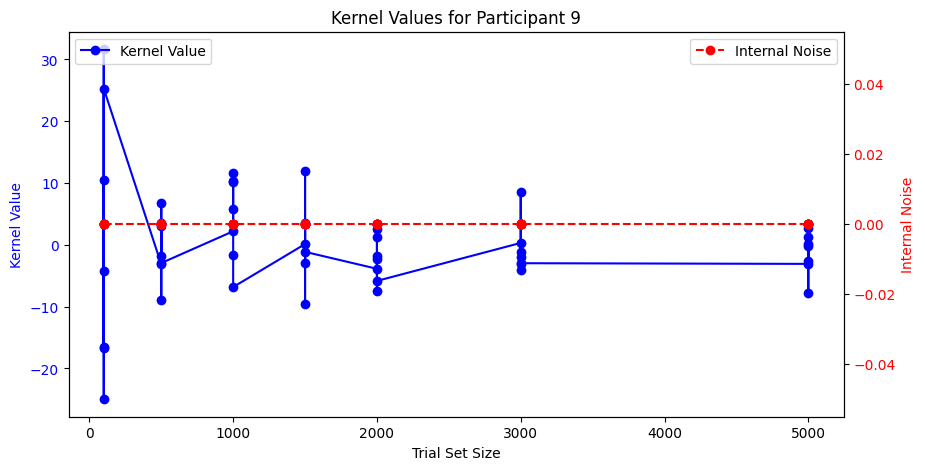

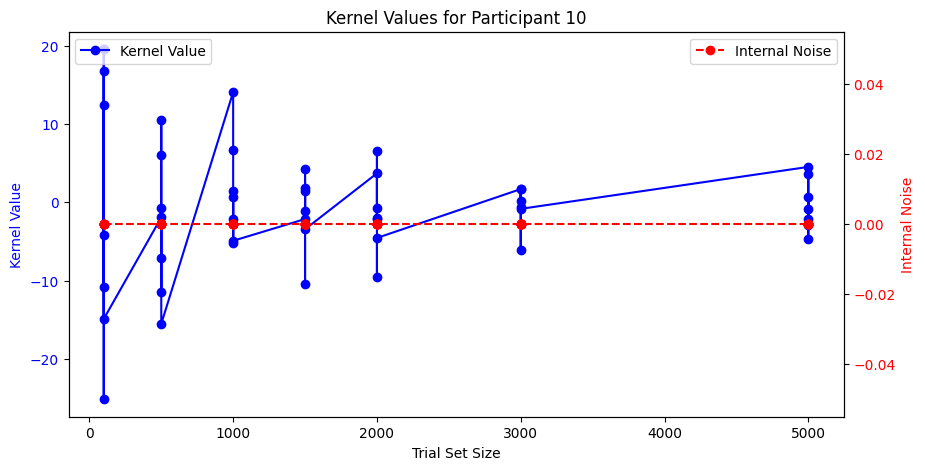

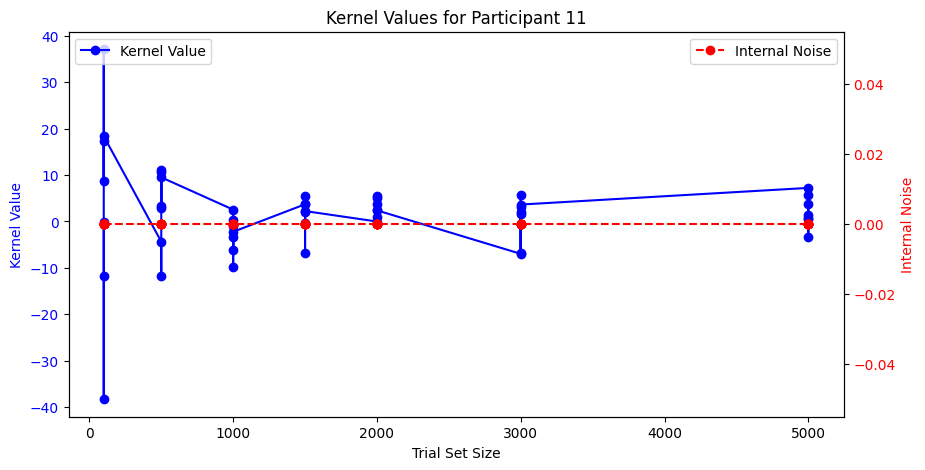

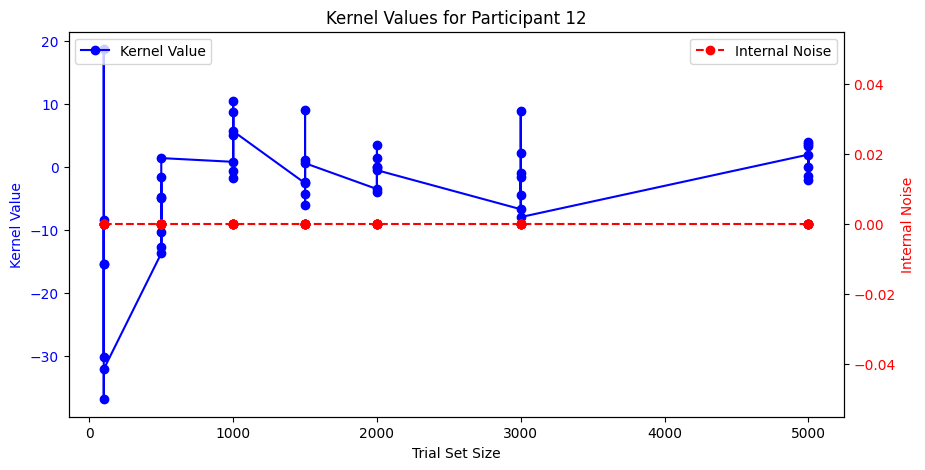

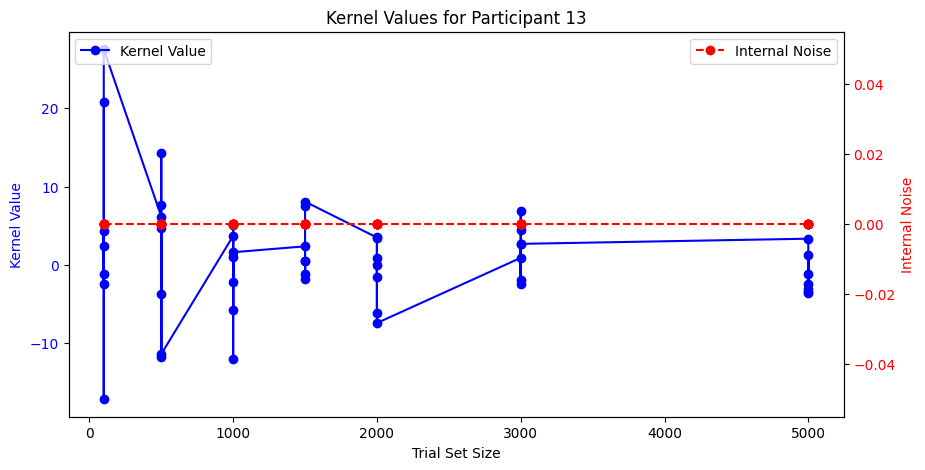

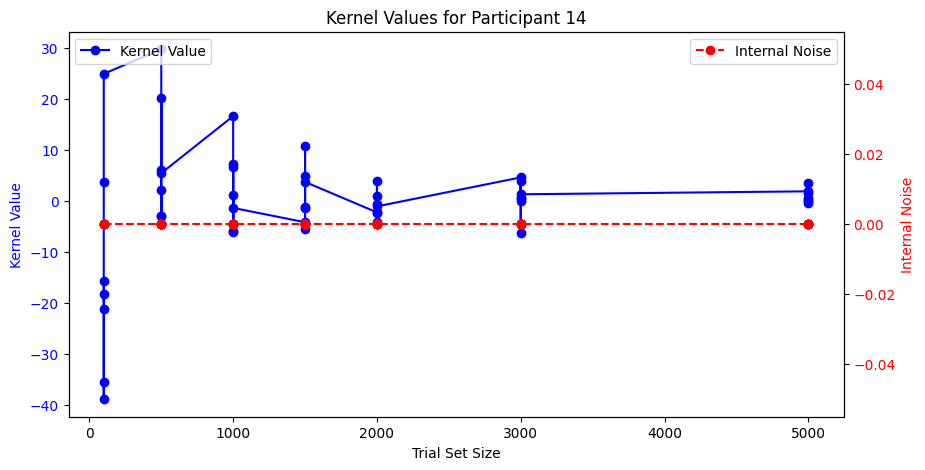

In [97]:
import matplotlib.pyplot as plt

# Iterate over each participant
for participant_num in combined_kernels_df['participant_num'].unique():
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Extract the data for the current participant
    participant_data = combined_kernels_df[combined_kernels_df['participant_num'] == participant_num]

    # Sort data by 'trial_set_size' if it's not already sorted
    participant_data = participant_data.sort_values('trial_set_size')

    # Plot 'kernel_value' on the primary y-axis with markers and lines
    ax1.plot(participant_data['trial_set_size'], participant_data['kernel_value'], marker='o', linestyle='-', color='b', label='Kernel Value')
    ax1.set_xlabel('Trial Set Size')
    ax1.set_ylabel('Kernel Value', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.set_title(f'Kernel Values for Participant {participant_num}')

    # Create a secondary y-axis for 'internal_noise' with markers and lines
    ax2 = ax1.twinx()
    ax2.plot(participant_data['trial_set_size'], participant_data['internal_noise'], marker='o', linestyle='--', color='r', label='Internal Noise')
    ax2.set_ylabel('Internal Noise', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    # Add legends to the plot
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.show()


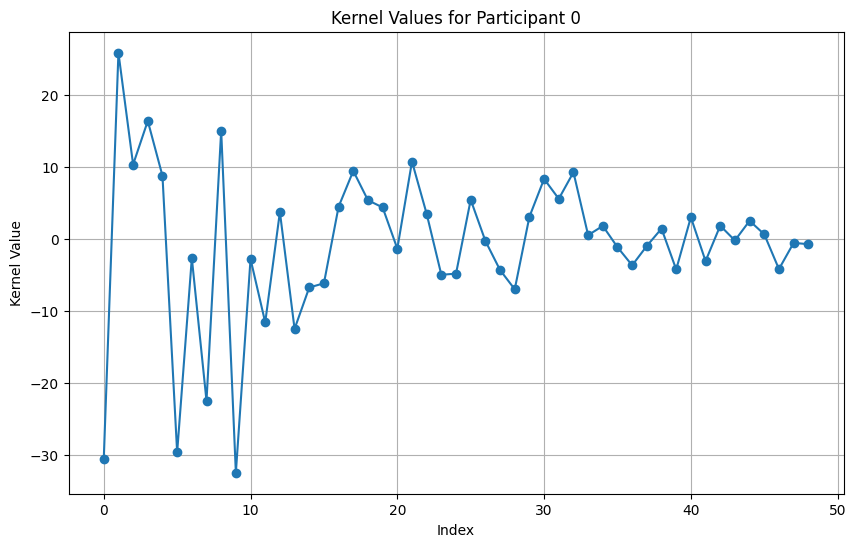

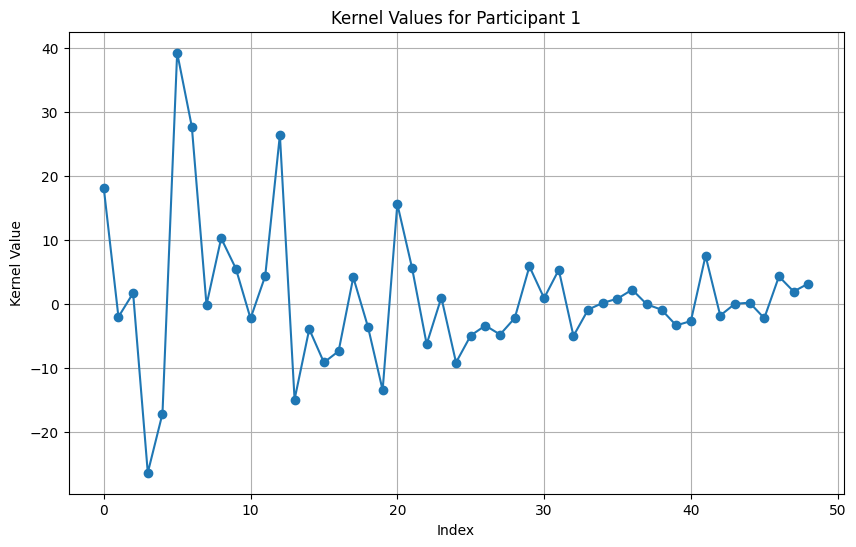

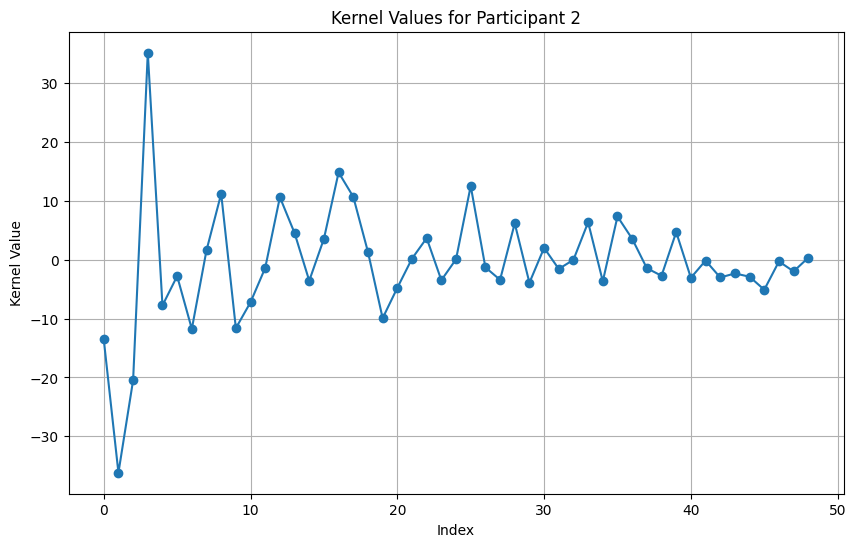

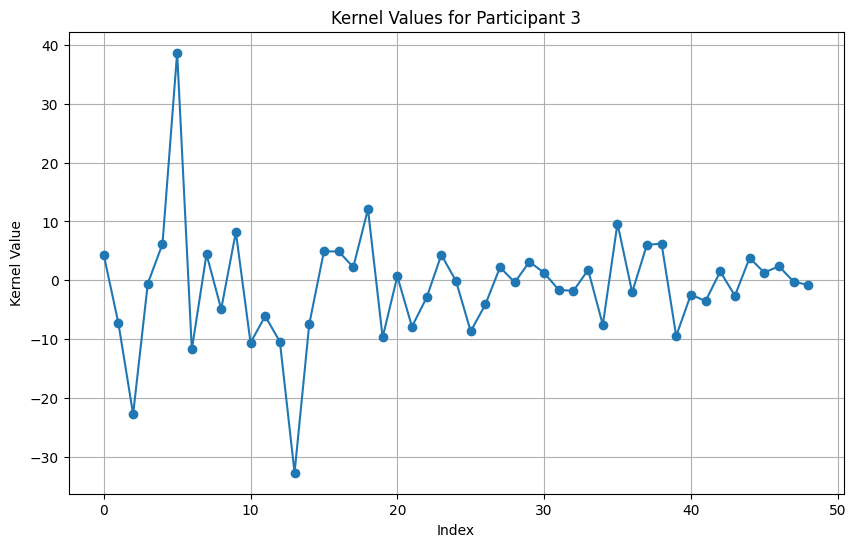

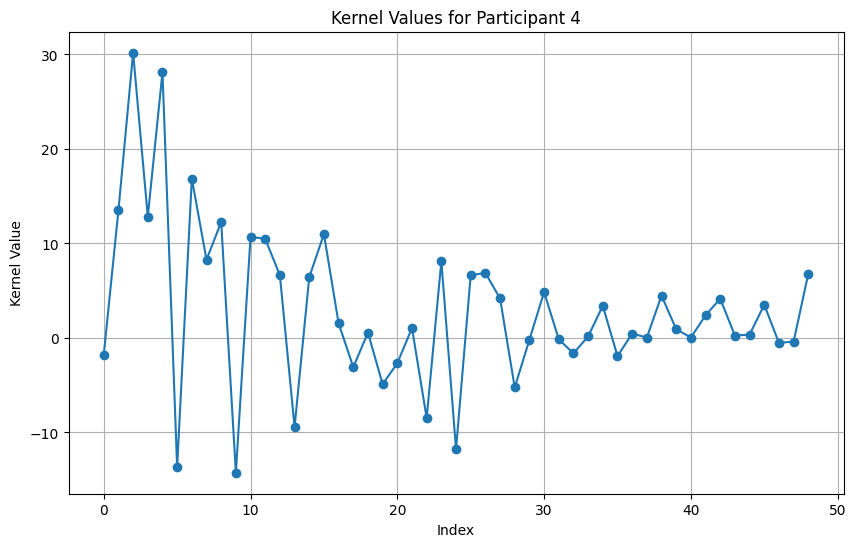

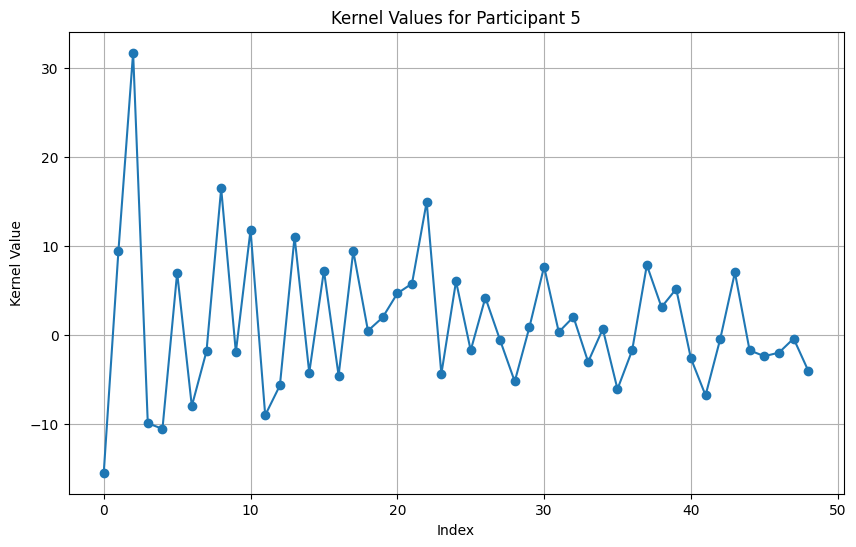

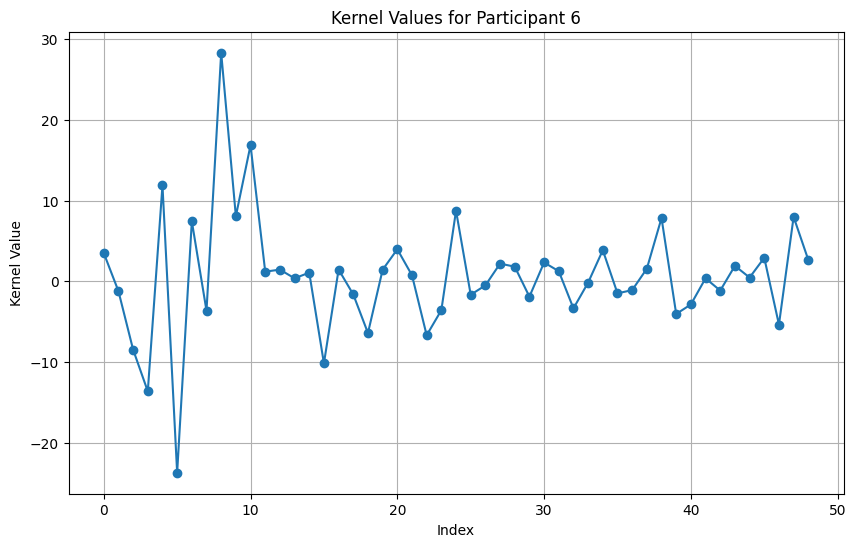

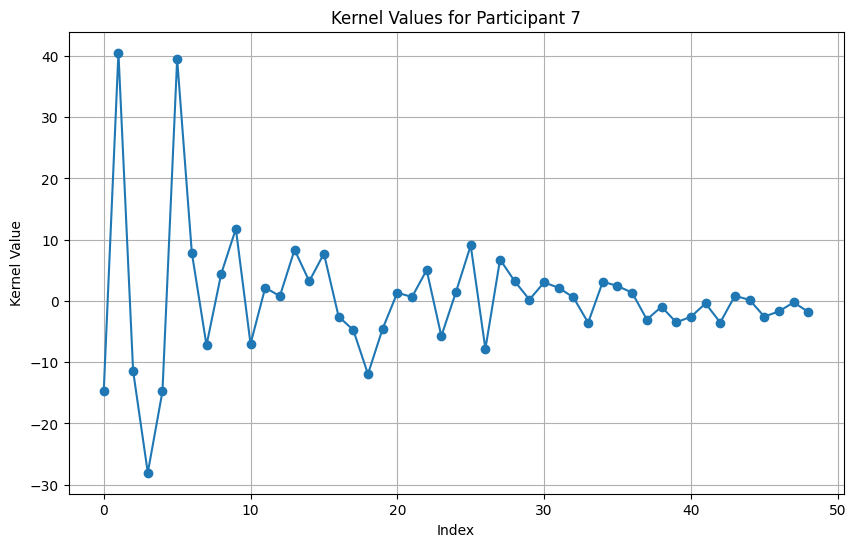

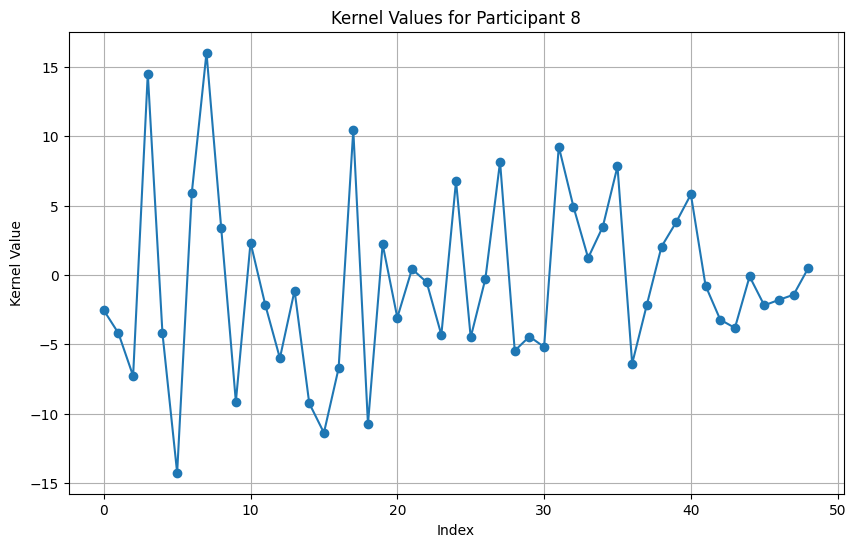

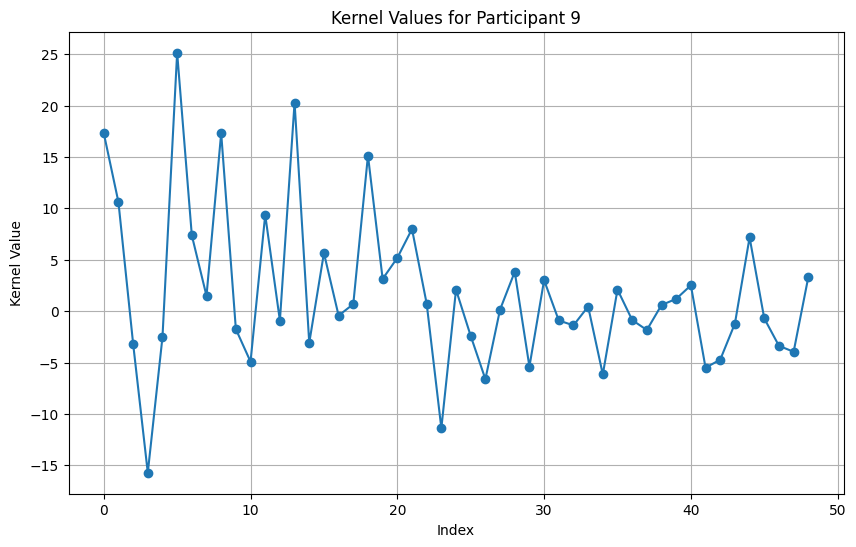

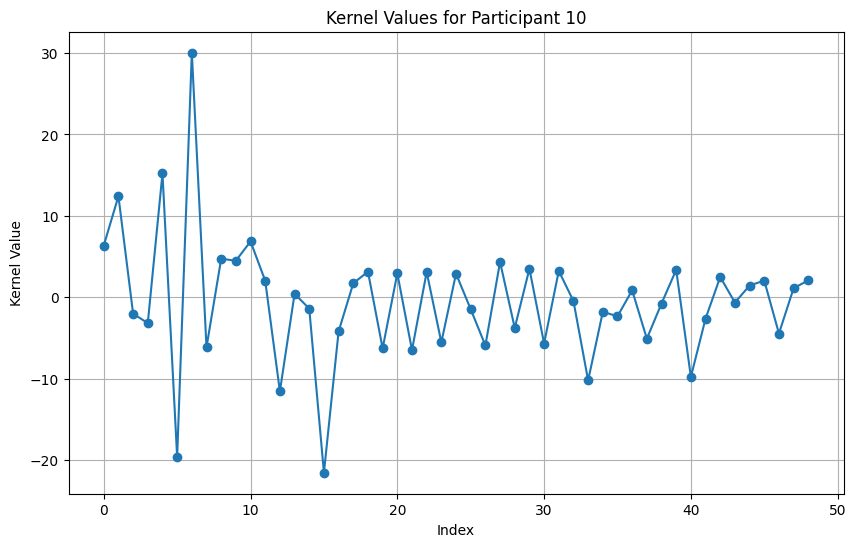

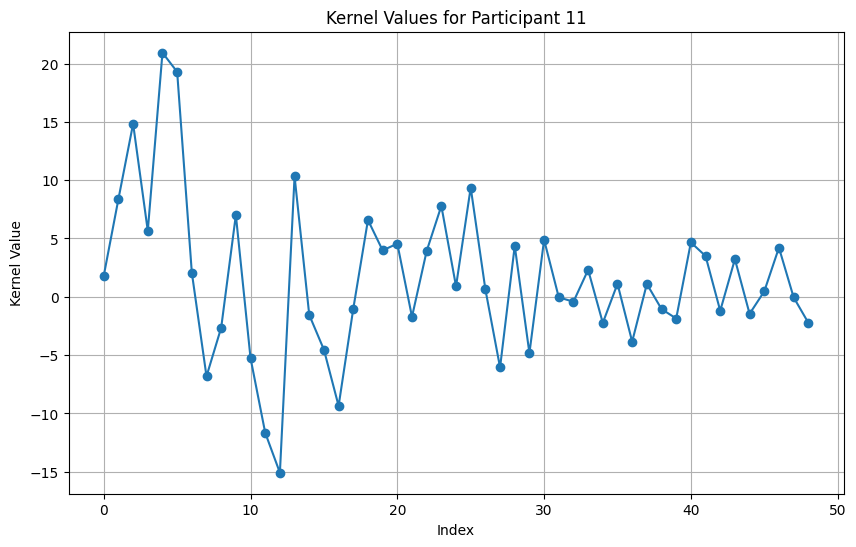

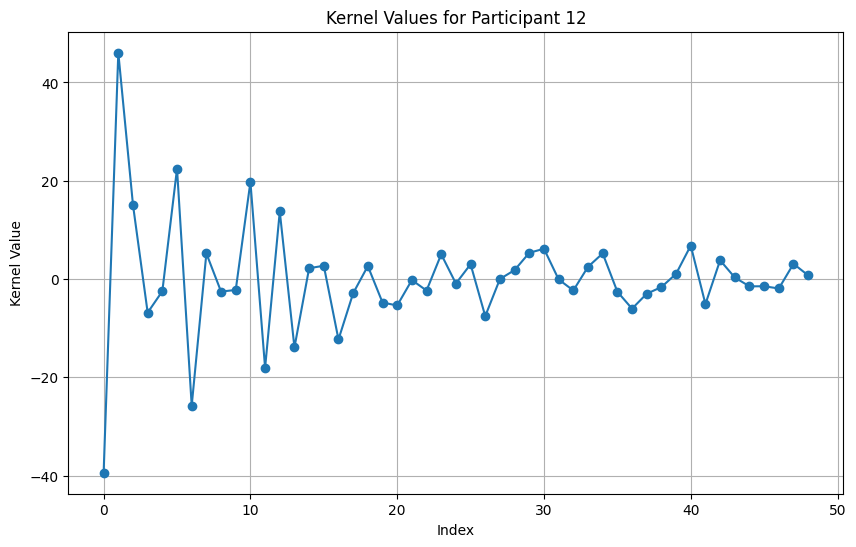

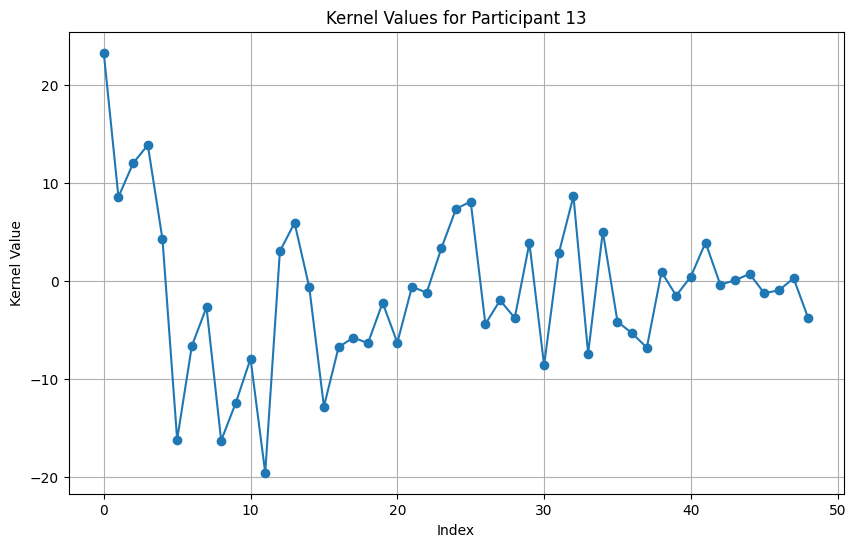

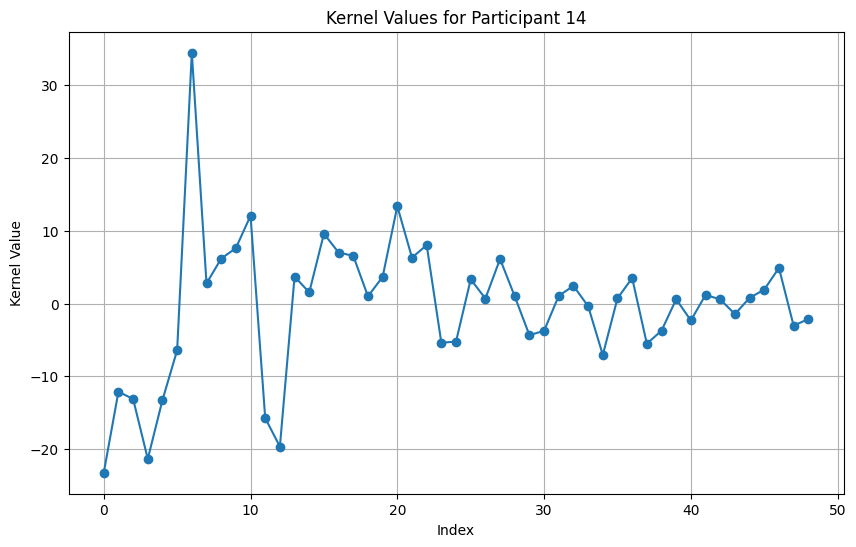

In [84]:
import matplotlib.pyplot as plt

# Loop through each participant's kernel data
for i, kernel_df in enumerate(all_kernels):
    # Check if 'kernel_value' column exists
    if 'kernel_value' in kernel_df.columns:
        # Plot the 'kernel_value' column
        plt.figure(figsize=(10, 6))
        plt.plot(kernel_df['kernel_value'], marker='o', linestyle='-')
        plt.title(f'Kernel Values for Participant {i}')
        plt.xlabel('Index')
        plt.ylabel('Kernel Value')
        plt.grid(True)
        plt.show()
    else:
        print(f"Participant {i}'s data does not have a 'kernel_value' column.")


### correlation with participant random kernel

Index(['trial_set_size', 'participant_num', 'correlation'], dtype='object')


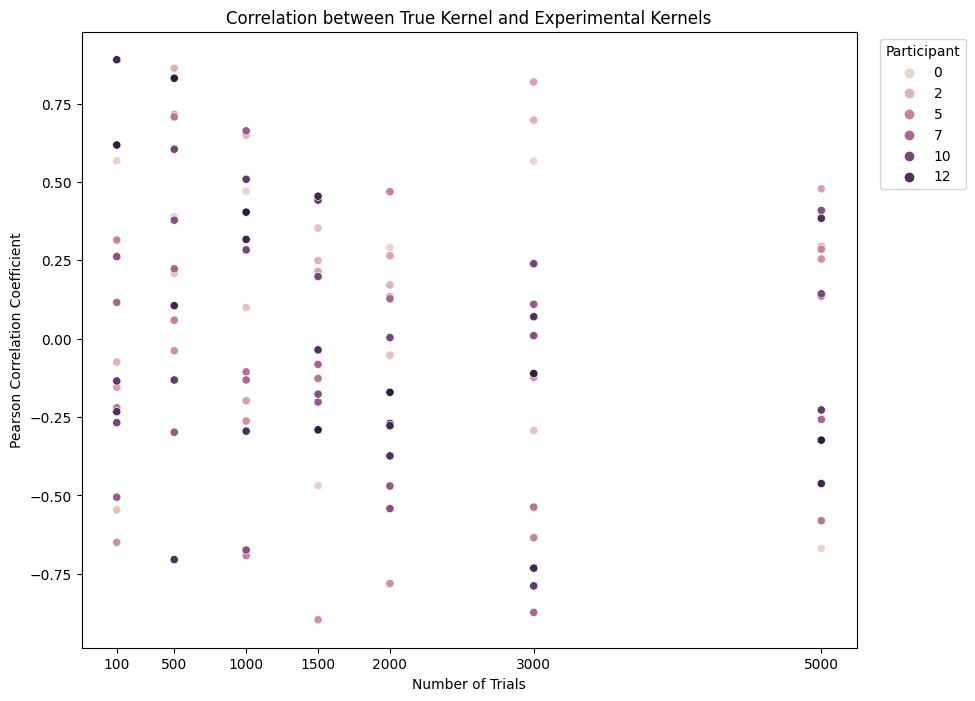

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt
particpant_kernel=pd.DataFrame(kernel,columns=['pitch'])
particpant_kernel['segment']= range(7)
particpant_kernel_df = particpant_kernel['pitch'].values

# Initialize a list to store the correlation results
# Initialize a list to store the correlation results
correlation_results = []

# Calculate correlation for each unique num_trials and repetition
for num_trials in combined_kernels_df['trial_set_size'].unique():
    for participant in combined_kernels_df['participant_num'].unique():
        # Filter the data for the current num_trials and repetition
        filtered_data = combined_kernels_df[(combined_kernels_df['trial_set_size'] == num_trials) &
                                   (combined_kernels_df['participant_num'] == participant)]
        
        # Ensure that the length of the data matches
        if len(filtered_data) == len(true_kernel_values):
            # Calculate the Pearson correlation coefficient
            correlation = np.corrcoef(particpant_kernel_df, filtered_data['kernel_value'])[0, 1]
            # Append to the results list
            correlation_results.append({
                'trial_set_size': num_trials,
                'participant_num': participant,
                'correlation': correlation
            })

# Convert the results to a DataFrame
correlation_df = pd.DataFrame(correlation_results)
print(correlation_df.columns)

# Create the scatter plot
plt.figure(figsize=(10, 8))
scatter_plot = sns.scatterplot(data=correlation_df, x='trial_set_size', y='correlation', hue='participant_num')
plt.xticks([100, 500, 1000, 1500, 2000,3000,5000])
# Add a legend and titles
plt.title('Correlation between True Kernel and Experimental Kernels')
plt.xlabel('Number of Trials')
plt.ylabel('Pearson Correlation Coefficient')
plt.legend(title='Participant', loc='upper right', bbox_to_anchor=(1.15, 1))

# Show the plot
plt.show()

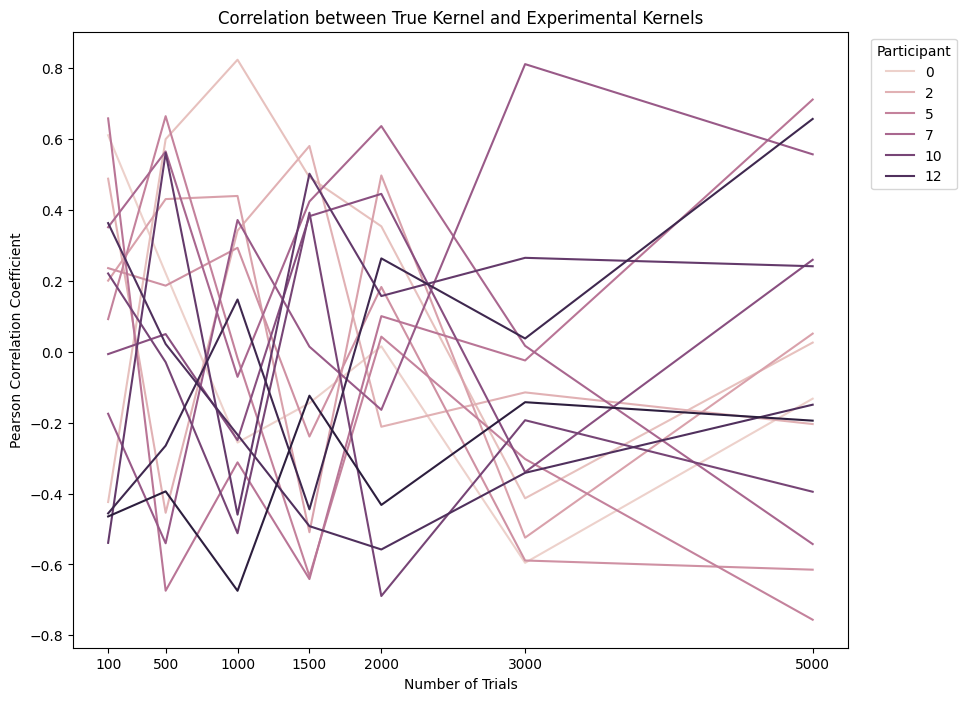

In [98]:
# Create the line plot with confidence intervals
plt.figure(figsize=(10, 8))
line_plot = sns.lineplot(data=correlation_df, x='trial_set_size', y='correlation', hue='participant_num', ci='sd')

# Customize the plot
plt.xticks([100, 500, 1000, 1500, 2000, 3000, 5000])
plt.title('Correlation between True Kernel and Experimental Kernels')
plt.xlabel('Number of Trials')
plt.ylabel('Pearson Correlation Coefficient')
plt.legend(title='Participant', loc='upper right', bbox_to_anchor=(1.15, 1))

# Show the plot
plt.show()

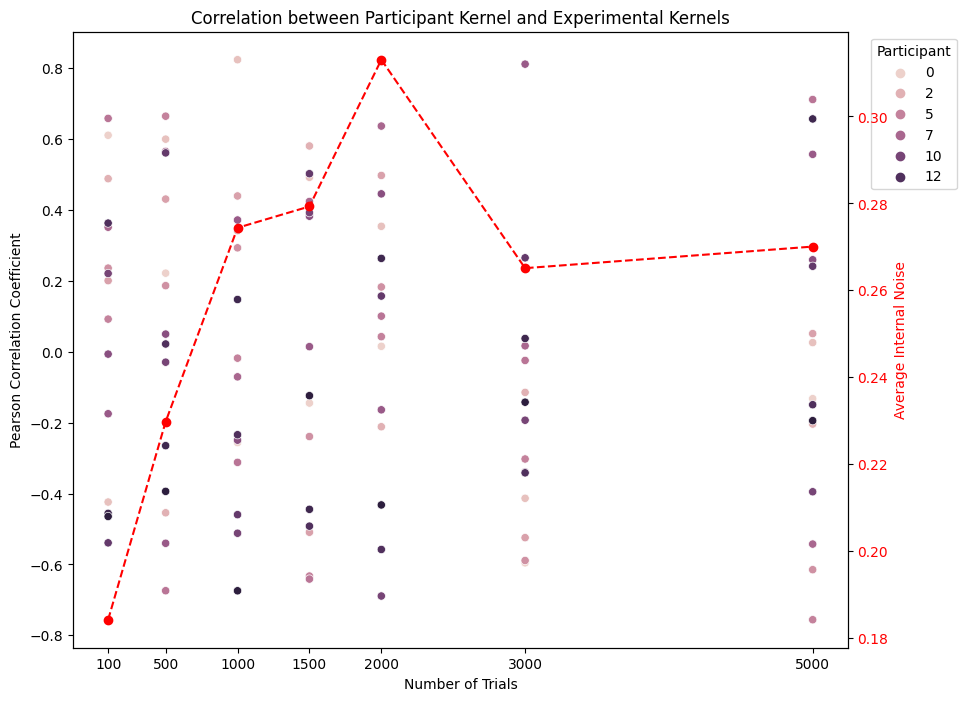

In [70]:
plt.figure(figsize=(10, 8))
ax1 = plt.gca()

# Use Seaborn to create the scatter plot on the primary y-axis
scatter_plot = sns.scatterplot(data=correlation_df, x='trial_set_size', y='correlation', hue='participant_num', ax=ax1)
plt.xticks([100, 500, 1000, 1500, 2000, 3000, 5000])
plt.title('Correlation between Participant Kernel and Experimental Kernels')
plt.xlabel('Number of Trials')
plt.ylabel('Pearson Correlation Coefficient')
plt.legend(title='Participant', loc='upper right', bbox_to_anchor=(1.15, 1))

# Create secondary y-axis
ax2 = ax1.twinx()

# Calculate the average internal noise for each trial_set_size
average_noise = combined_kernels_df.groupby('trial_set_size')['internal_noise'].mean()

# Plot the average internal noise on the secondary y-axis
ax2.plot(average_noise.index, average_noise, color='r', marker='o', linestyle='--')
ax2.set_ylabel('Average Internal Noise', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Show the plot with both y-axes
plt.show()

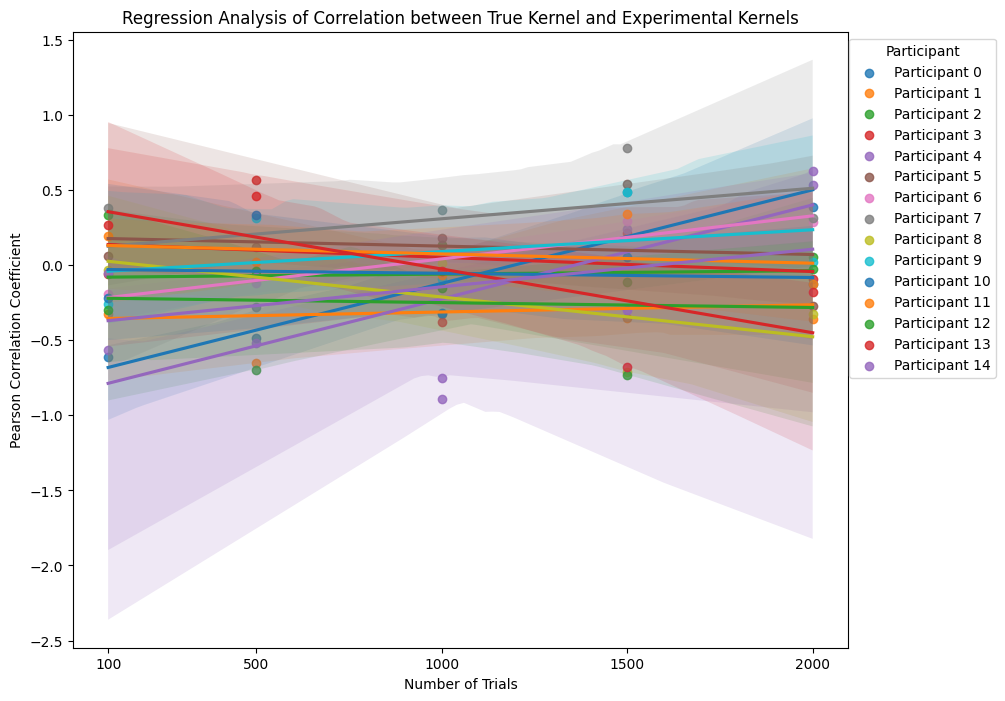

In [36]:
plt.figure(figsize=(10, 8))

# Loop through each participant to create a regplot for each one
for participant in correlation_df['participant_num'].unique():
    participant_data = correlation_df[correlation_df['participant_num'] == participant]
    sns.regplot(data=participant_data, x='trial_set_size', y='correlation', label=f'Participant {participant}')

plt.xticks([100, 500, 1000, 1500, 2000])
plt.title('Regression Analysis of Correlation between True Kernel and Experimental Kernels')
plt.xlabel('Number of Trials')
plt.ylabel('Pearson Correlation Coefficient')
plt.legend(title='Participant', loc='upper right', bbox_to_anchor=(1.2, 1))

# Show the plot
plt.show()

## different values of IN and Criteria

In [27]:
# Number of participants
num_participants = 15

# Size of the kernel
kernel_size = 7

# Range for the random kernel generation
kernel_low, kernel_high = -10, 10

# Trial sets for the simulation
trial_sets = [100, 500, 1000, 1500, 2000]

# Define the pitch configuration once, if it's the same for all participants
pitch_config = {'std_semitones': 150, 'num_segments': kernel_size}

# This will store the DataFrame for each participant and each trial set
all_participant_data = []

# Loop over the number of participants
for participant_num in range(num_participants):
    # Generate a unique kernel for each participant
    kernel = generate_random_kernel(kernel_size, kernel_low, kernel_high)
    
    # Create a participant instance
    participant = SimulatedParticipant(kernel)
    
    # For each trial set size
    for num_trials in trial_sets:
        # Generate trial data for the participant
        trials_df = generate_trials(pitch_config, num_trials)
        
        # Assign random criteria and internal noise for each trial
        trials_df['criteria'] = generate_random_criteria(0, 1)  # Adjust the range as needed
        trials_df['internal_noise'] = generate_random_std(0, 1)  # Adjust the range as needed
        
        # Simulate the participant's response to each trial
        response_data = trials_df.groupby('trial').apply(
        lambda group: participant.respond_to(
            group[group['stim_order'] == 0]['value'].values, 
            group[group['stim_order'] == 1]['value'].values, 
            group['criteria'].iloc[0], 
            group['internal_noise'].iloc[0]
        )
    )
        
        # Add the participant number and trial set size to the DataFrame
        trials_df['participant_num'] = participant_num
        trials_df['trial_set_size'] = num_trials
        trials_df['response'] = response_data.reindex(trials_df['trial']).reset_index(drop=True).values
        
        # Append the participant's trial data to the list
        all_participant_data.append(trials_df)

# Combine all participant data into a single DataFrame
all_data_df = pd.concat(all_participant_data, ignore_index=True)

In [ ]:
# Number of participants
num_participants = 15

# Size of the kernel
kernel_size = 7

# Range for the random kernel generation
kernel_low, kernel_high = -10, 10

# Trial sets for the simulation
trial_sets = [100, 500, 1000, 1500, 2000]

# Define the pitch configuration once, if it's the same for all participants
pitch_config = {'std_semitones': 150, 'num_segments': kernel_size}

# This will store the DataFrame for each participant and each trial set
all_participant_data = []
kernel = generate_random_kernel(kernel_size, kernel_low, kernel_high)
# Loop over the number of participants
for participant_num in range(num_participants):
    # Generate a unique kernel for each participant

    # Create a participant instance
    participant = SimulatedParticipant(kernel)
    
    # For each trial set size
    for num_trials in trial_sets:
        # Generate trial data for the participant
        trials_df = generate_trials(pitch_config, num_trials)
        
        # Assign random criteria and internal noise for each trial
        trials_df['criteria'] = generate_random_criteria(0, 1)  # Adjust the range as needed
        trials_df['internal_noise'] = generate_random_std(0, 1)  # Adjust the range as needed
        
        # Simulate the participant's response to each trial
        response_data = trials_df.groupby('trial').apply(
        lambda group: participant.respond_to(
            group[group['stim_order'] == 0]['value'].values, 
            group[group['stim_order'] == 1]['value'].values, 
            group['criteria'].iloc[0], 
            group['internal_noise'].iloc[0]
        )
    )
        
        # Add the participant number and trial set size to the DataFrame
        trials_df['participant_num'] = participant_num
        trials_df['trial_set_size'] = num_trials
        trials_df['response'] = response_data.reindex(trials_df['trial']).reset_index(drop=True).values
        
        # Append the participant's trial data to the list
        all_participant_data.append(trials_df)

# Combine all participant data into a single DataFrame
all_data_df = pd.concat(all_participant_data, ignore_index=True)

In [28]:
all_data_df

trial  stim_order  segment      time       value  criteria  \
0           0.0         0.0        0  0.000000  -19.565746  0.408571   
1           0.0         0.0        1  0.142857  -64.709268  0.408571   
2           0.0         0.0        2  0.285714   41.283058  0.408571   
3           0.0         0.0        3  0.428571  -24.842052  0.408571   
4           0.0         0.0        4  0.571429 -167.941753  0.408571   
...         ...         ...      ...       ...         ...       ...   
1070995  1999.0         1.0        2  0.285714  -72.771593  0.662327   
1070996  1999.0         1.0        3  0.428571   16.670023  0.662327   
1070997  1999.0         1.0        4  0.571429   -9.566755  0.662327   
1070998  1999.0         1.0        5  0.714286   76.349086  0.662327   
1070999  1999.0         1.0        6  0.857143   34.532455  0.662327   

         internal_noise  participant_num  trial_set_size  response  
0              0.312003                0             100         1  
1              0.312003                0             100         1  
2              0.312003                0             100         1  
3              0.312003                0             100         1  
4              0.312003                0             100         1  
...                 ...              ...             ...       ...  
1070995        0.257084               14            2000         0  
1070996        0.257084               14            2000         0  
1070997        0.257084               14            2000         0  
1070998        0.257084               14            2000         0  
1070999        0.257084               14            2000         0  

[1071000 rows x 10 columns]

In [29]:
trial_ids=['trial_set_size', 'internal_noise', 'criteria','participant_num']
kernels=classification_images.compute_kernel(all_data_df,trial_ids,'segment','response','value')
kernels

trial_set_size  internal_noise  criteria  participant_num  segment  \
0               100        0.003308  0.236691                5        0   
1               100        0.003308  0.236691                5        1   
2               100        0.003308  0.236691                5        2   
3               100        0.003308  0.236691                5        3   
4               100        0.003308  0.236691                5        4   
..              ...             ...       ...              ...      ...   
520            2000        0.997552  0.284317               13        2   
521            2000        0.997552  0.284317               13        3   
522            2000        0.997552  0.284317               13        4   
523            2000        0.997552  0.284317               13        5   
524            2000        0.997552  0.284317               13        6   

     kernel_value  norm_value  
0       29.964811    1.242120  
1       25.304157    1.048923  
2        9.589377    0.397505  
3       29.687332    1.230618  
4       39.337961    1.630661  
..            ...         ...  
520     -5.886112   -1.023937  
521      0.759613    0.132141  
522     -7.687472   -1.337298  
523     -6.667887   -1.159933  
524     -2.594919   -0.451407  

[525 rows x 7 columns]

Index(['trial_set_size', 'participant_num', 'correlation'], dtype='object')


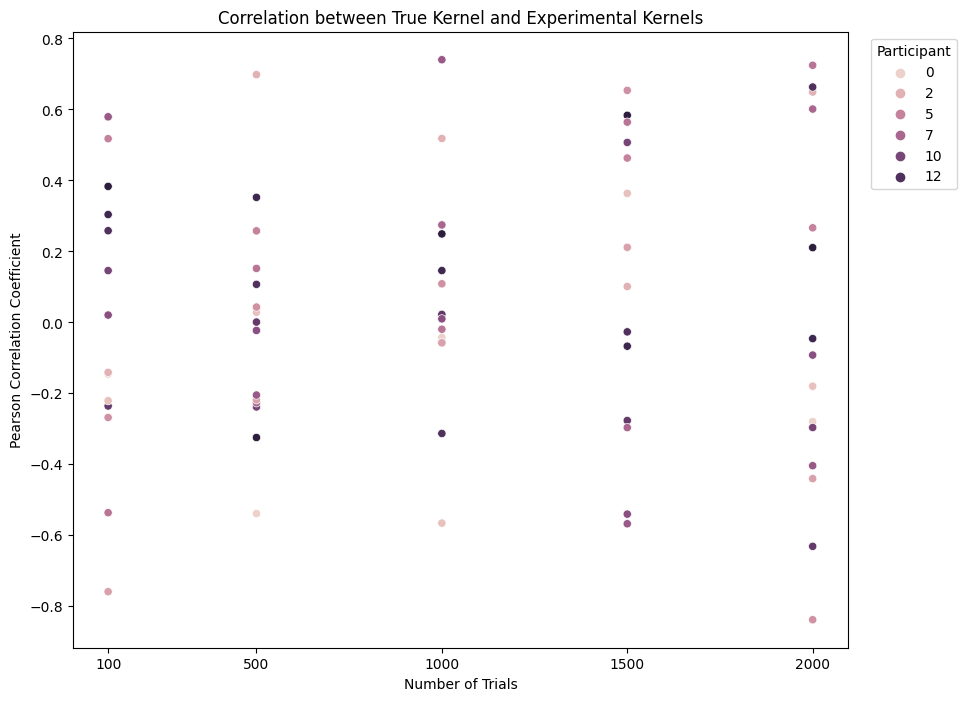

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
true_kernel_values=pd.DataFrame(kernel,columns=['pitch'])
true_kernel_values['segment']= range(7)
true_kernel_values = true_kernel_values['pitch'].values

# Initialize a list to store the correlation results
# Initialize a list to store the correlation results
correlation_results = []

# Calculate correlation for each unique num_trials and repetition
for num_trials in kernels['trial_set_size'].unique():
    for participant in kernels['participant_num'].unique():
        # Filter the data for the current num_trials and repetition
        filtered_data = kernels[(kernels['trial_set_size'] == num_trials) &
                                   (kernels['participant_num'] == participant)]
        
        # Ensure that the length of the data matches
        if len(filtered_data) == len(true_kernel_values):
            # Calculate the Pearson correlation coefficient
            correlation = np.corrcoef(true_kernel_values, filtered_data['kernel_value'])[0, 1]
            # Append to the results list
            correlation_results.append({
                'trial_set_size': num_trials,
                'participant_num': participant,
                'correlation': correlation
            })

# Convert the results to a DataFrame
correlation_df = pd.DataFrame(correlation_results)
print(correlation_df.columns)

# Create the scatter plot
plt.figure(figsize=(10, 8))
scatter_plot = sns.scatterplot(data=correlation_df, x='trial_set_size', y='correlation', hue='participant_num')
#sns.regplot(data=correlation_df, x="trial_set_size", y="correlation", hue="participant_num" ,ci=80)

plt.xticks([100, 500, 1000, 1500, 2000])
# Add a legend and titles
plt.title('Correlation between True Kernel and Experimental Kernels')
plt.xlabel('Number of Trials')
plt.ylabel('Pearson Correlation Coefficient')
plt.legend(title='Participant', loc='upper right', bbox_to_anchor=(1.15, 1))

# Show the plot
plt.show()

In [17]:
def createBPF(std_semitones, num_segments):
    BPFtime = np.linspace(0, 1, num_segments + 1)[:-1]
    BPFval = np.random.normal(loc=0, scale=std_semitones, size=num_segments)
    return range(num_segments), BPFtime, BPFval

In [147]:
def generate_trials(pitch_config, num_trials):
    ''' Generate a df of trials, each of which consists of 2 stimuli, with a random pitch contour
    '''   
    trials=[]
    stim_orders =[]
    segments =  []
    times = []
    values = [] 
    
    for trial in range(num_trials): 
        
        for stim_order in range(2): 
            stim_segments, stim_times, stim_values = createBPF(pitch_config['std_semitones'], pitch_config['num_segments'])
            trials += list(trial * np.ones(pitch_config['num_segments'])) 
            stim_orders += list(stim_order * np.ones(pitch_config['num_segments'])) 
            segments += list(stim_segments)
            times += list(stim_times)
            values += list(stim_values)
     
    return pd.DataFrame.from_dict({'trial': trials,
                           'stim_order': stim_orders,
                           'segment': segments,
                           'time':times,
                           'value':values})

pitch_config = {'std_semitones': 150,
                'num_segments':7}
trials_df = generate_trials(pitch_config, 10)
trials_df

trial  stim_order  segment      time       value
0      0.0         0.0        0  0.000000 -129.307083
1      0.0         0.0        1  0.142857 -203.498626
2      0.0         0.0        2  0.285714    2.634556
3      0.0         0.0        3  0.428571  111.525485
4      0.0         0.0        4  0.571429  105.691148
..     ...         ...      ...       ...         ...
135    9.0         1.0        2  0.285714  -16.591371
136    9.0         1.0        3  0.428571   86.491517
137    9.0         1.0        4  0.571429   58.219637
138    9.0         1.0        5  0.714286 -101.377753
139    9.0         1.0        6  0.857143  -83.037381

[140 rows x 5 columns]

In [148]:
class SimulatedParticipant: 
    
    def __init__(this, kernel,criteria, internal_noise_std): 
        this.kernel = kernel
        this.criteria = criteria
        this.internal_noise_std = internal_noise_std
        
    def respond_to(this,stim_0, stim_1): 
        activity_stim_0 = np.dot(stim_0, this.kernel)
        #print('Activity of stim %s compared to kernel %s: %f'%(stim_0,this.kernel,activity_stim_0))
        activity_stim_1 = np.dot(stim_1, this.kernel)
        #print('Activity of stim %s compared to kernel %s: %f'%(stim_1,this.kernel,activity_stim_1))
        internal_noise = np.random.normal(loc=0, scale=this.internal_noise_std)
        response = 0 if (activity_stim_0 - activity_stim_1 + internal_noise >= this.criteria) else 1
        #print('activity(%f) + noise (%f) <?> activity(%f) + criteria (%f)'%(activity_stim_0,
        #                                                                   internal_noise,
        #                                                                   activity_stim_1, 
        #                                                                   this.criteria))
        
        return response
    
participant = SimulatedParticipant(kernel=[0,0,0,0,5,10,5],
                                   criteria=0,
                                   internal_noise_std = 0)
#participant.respond_to([0,0,0,0,0,2,2], [0,0,0,0,0,-1,-2])    

In [149]:
# Applying the respond_to function and creating a new DataFrame for responses
response_series = trials_df.groupby('trial').apply(lambda group: participant.respond_to(group[group.stim_order == 0].value.values, 
                                                                                        group[group.stim_order == 1].value.values))
response_df = pd.DataFrame({'trial': response_series.index, 'response': response_series.values})

# Merging the response_df with trials_df
trials_df = trials_df.merge(response_df, on='trial')
trials_df

trial  stim_order  segment      time       value  response
0      0.0         0.0        0  0.000000 -129.307083         0
1      0.0         0.0        1  0.142857 -203.498626         0
2      0.0         0.0        2  0.285714    2.634556         0
3      0.0         0.0        3  0.428571  111.525485         0
4      0.0         0.0        4  0.571429  105.691148         0
..     ...         ...      ...       ...         ...       ...
135    9.0         1.0        2  0.285714  -16.591371         0
136    9.0         1.0        3  0.428571   86.491517         0
137    9.0         1.0        4  0.571429   58.219637         0
138    9.0         1.0        5  0.714286 -101.377753         0
139    9.0         1.0        6  0.857143  -83.037381         0

[140 rows x 6 columns]

In [178]:
trials_df[trials_df.response==1].groupby(['internal_noise','criteria']).response.nunique().head(60)

internal_noise  criteria 
0.000095        -4.828782    1
0.002691        -4.972013    1
0.003765        -0.259331    1
0.007934         1.204770    1
0.009887        -4.645546    1
0.014136        -1.990318    1
0.015242        -3.193134    1
0.015908         0.365097    1
0.017225        -4.959391    1
0.019611         1.822746    1
0.024809         0.096813    1
0.025610         4.084103    1
0.027130         3.345213    1
0.027161        -4.176310    1
0.027927        -4.321507    1
0.028947         2.636389    1
0.029810         1.317898    1
0.033000         2.726408    1
0.033629         1.251314    1
0.038334         3.720003    1
0.043826        -0.505158    1
0.046110         3.772890    1
0.048334         3.557375    1
0.048942        -0.442885    1
0.050085        -1.607721    1
0.052860         3.606875    1
0.053365        -2.731665    1
0.053543         3.504383    1
0.056066        -2.672843    1
0.057026         4.734850    1
0.058588        -2.331079    1
0.058740     

In [137]:
response_df = trials_df.groupby('trial', as_index=False).apply(lambda group: participant.respond_to(group[group.stim_order==0].value,
                                                                                                  group[group.stim_order==1].value))
trials_df = trials_df.merge(response_df, left_on = 'trial', right_on = 'trial').reset_index()



In [138]:
trials_df.columns

Index(['index', 'trial', 'stim_order', 'segment', 'time', 'value', None], dtype='object')

In [86]:
def simulate_trials(true_kernel, std, min_diff, num_trials, num_repetitions, num_segments):
    std_semitones = std / 100
    min_diff_semitones = min_diff / 100  # Convert minimum difference to semitones
    all_trials_data = []

    for repetition in range(num_repetitions):
        for trial in range(num_trials):
            for segment in range(num_segments):
                valid_shift = False
                while not valid_shift:
                    # Generate a pitch shift for stim_order 0
                    pitch_shift_stim0 = np.random.normal(0, std_semitones)
                    # Generate a different pitch shift for stim_order 1
                    pitch_shift_stim1 = np.random.normal(0, std_semitones)
                    
                    # Check if the difference between pitch shifts meets the minimum required difference
                    if np.abs(pitch_shift_stim1 - pitch_shift_stim0) >= min_diff_semitones:
                        valid_shift = True

                # 
                pitch_value_stim0 = true_kernel[segment, 2] + pitch_shift_stim0
                pitch_value_stim1 = true_kernel[segment, 2] + pitch_shift_stim1
                
                # Append data for both stim_orders
                all_trials_data.append([repetition, trial, segment, 0, pitch_value_stim0])
                all_trials_data.append([repetition, trial, segment, 1, pitch_value_stim1])

    return pd.DataFrame(all_trials_data, columns=['Repetition', 'Trial Number', 'Segment', 'Stim Order', 'Pitch'])

# Configuration and parameters for BPF and trials

pitch_config = {'std_semitones': 150,
                'num_segments':7}




num_repetitions = 10  # Number of repetitions for each trial set
trial_sets = [100, 500, 1000, 1500, 2000]  # Example trial set sizes
min_diff = 50  # or any other value that suits your experimental design

# Use a random pitch profile as the "true" kernel
true_kernel_BPF = createBPF("pitch", pitch_config, num_segments, end_on_trans)

# Simulate trials for each trial set size and concatenate into a single DataFrame
all_trials_data = []
for num_trials in trial_sets:
    simulated_data = simulate_trials(true_kernel_BPF, std, min_diff, num_trials, num_repetitions, num_segments)
    simulated_data['Trial Set Size'] = num_trials  # Add a column for the trial set size after the simulation
    all_trials_data.append(simulated_data)

# Concatenate all DataFrames into one

# Concatenate all DataFrames into one
all_simulated_data = pd.concat(all_trials_data).reset_index(drop=True)

# Check the DataFrame
all_simulated_data

Repetition  Trial Number  Segment  Stim Order     Pitch  \
0                0             0        0           0 -3.382714   
1                0             0        0           1 -2.332776   
2                0             0        1           0 -8.501603   
3                0             0        1           1 -6.301850   
4                0             0        2           0  9.735252   
...            ...           ...      ...         ...       ...   
713995           9          1999        4           1 -3.826343   
713996           9          1999        5           0  6.437504   
713997           9          1999        5           1  5.593930   
713998           9          1999        6           0 -4.761726   
713999           9          1999        6           1 -2.227624   

        Trial Set Size  
0                  100  
1                  100  
2                  100  
3                  100  
4                  100  
...                ...  
713995            2000  
713996            2000  
713997            2000  
713998            2000  
713999            2000  

[714000 rows x 6 columns]

In [ ]:
def simulate_experiment_responses(simulated_data, noise_range, criterion_range, num_segments):
    all_responses = []  # This is the correct variable name as initialized

    # Generate arrays of noise and criterion values using the provided ranges
    noise_values = np.arange(noise_range[0], noise_range[1], noise_range[2])
    criterion_values = np.arange(criterion_range[0], criterion_range[1], criterion_range[2])

    # Iterate over all combinations of noise and criterion values
    for noise_std in noise_values:
        for criterion in criterion_values:
            for (repetition, trial_number), trial_group in simulated_data.groupby(['Repetition', 'Trial Number']):
                # Initialize decision scores
                decision_scores = {0: 0, 1: 0}
                
                # Calculate decision scores for each segment
                for segment in range(num_segments):
                    # Retrieve the pitch values for both stimulus orders
                    pitch_0 = trial_group[(trial_group['Segment'] == segment) & (trial_group['Stim Order'] == 0)]['Pitch'].values[0]
                    pitch_1 = trial_group[(trial_group['Segment'] == segment) & (trial_group['Stim Order'] == 1)]['Pitch'].values[0]
                    
                    # Add internal noise to the pitch values
                    noisy_pitch_0 = pitch_0 + np.random.normal(0, noise_std)
                    noisy_pitch_1 = pitch_1 + np.random.normal(0, noise_std)
                    
                    # Compare noisy pitch values against the criterion to make decisions
                    decision_scores[0] += noisy_pitch_0 < criterion
                    decision_scores[1] += noisy_pitch_1 < criterion
                
                # Choose the stimulus order with the higher decision score as the trial response
                chosen_stim_order = 0 if decision_scores[0] > decision_scores[1] else 1

                # Retrieve the trial set size for this group
                trial_set_size = trial_group['Trial Set Size'].iloc[0]

                # Record the response for each segment and stimulus order
                for segment in range(num_segments):
                    all_responses.append({
                        'Repetition': repetition,
                        'Trial Number': trial_number,
                        'Segment': segment,
                        'Stim Order': 0,
                        'Pitch': pitch_0,
                        'Response': int(chosen_stim_order == 0),
                        'Internal Noise': noise_std,
                        'Criterion': criterion,
                        'Trial Set Size': trial_set_size,  # Include the trial set size
                    })
                    all_responses.append({
                        'Repetition': repetition,
                        'Trial Number': trial_number,
                        'Segment': segment,
                        'Stim Order': 1,
                        'Pitch': pitch_1,
                        'Response': int(chosen_stim_order == 1),
                        'Internal Noise': noise_std,
                        'Criterion': criterion,
                        'Trial Set Size': trial_set_size,  # Include the trial set size
                    })

    # Convert the list of response data into a DataFrame
    response_df = pd.DataFrame(all_responses)
    return response_df

# Define the noise standard deviation and criterion ranges
noise_std_range = [0.5, 1, 0.2]  # [start, stop, step]
criterion_range = [1, 3, 0.6]    # [start, stop, step]
num_segments = 7  # Number of segments per trial

# Assuming 'all_simulated_data' contains all the simulated trial data
all_responses_df = simulate_experiment_responses(all_simulated_data, noise_std_range, criterion_range, num_segments)


all_responses_df

In [87]:
def simulate_experiment_responses(simulated_data, noise_std, criterion, num_segments):
    # Initialize a list to hold response data
    response_data1 = []

    # Iterate over each trial to simulate responses
    for (repetition, trial_number), trial_group in simulated_data.groupby(['Repetition', 'Trial Number']):
        # Initialize decision scores for each stimulus order
        decision_scores = {0: 0, 1: 0}
        trial_set_size = trial_group['Trial Set Size'].iloc[0]


        # Calculate decision scores for each segment
        for segment in range(num_segments):
            # Retrieve the pitch values for both stimulus orders
            pitch_0 = trial_group[(trial_group['Segment'] == segment) & (trial_group['Stim Order'] == 0)]['Pitch'].values[0]
            pitch_1 = trial_group[(trial_group['Segment'] == segment) & (trial_group['Stim Order'] == 1)]['Pitch'].values[0]
            
            # Add internal noise to the pitch values
            noisy_pitch_0 = pitch_0 + np.random.normal(0, noise_std)
            noisy_pitch_1 = pitch_1 + np.random.normal(0, noise_std)
            
            # Compare noisy pitch values against the criterion to make decisions
            decision_scores[0] += noisy_pitch_0 < criterion
            decision_scores[1] += noisy_pitch_1 < criterion
        
        # Choose the stimulus order with the higher decision score as the trial response
        chosen_stim_order = 0 if decision_scores[0] >= decision_scores[1] else 1

        # Record the chosen response along with segment and stimulus order details
        for segment in range(num_segments):
            response_data1.append({
                'repetition': repetition,
                'trial': trial_number,
                'segment': segment,
                'stim_order': 0,  # Stimulus order 0
                'trial_set': trial_set_size,
                'pitch': trial_group[(trial_group['Segment'] == segment) & (trial_group['Stim Order'] == 0)]['Pitch'].values[0],
                'response': chosen_stim_order == 0,  # True if Stimulus order 0 was chosen
                'internal_noise': noise_std,
                'criterion': criterion
            })
            response_data1.append({
                'repetition': repetition,
                'trial': trial_number,
                'segment': segment,
                'stim_order': 1,  # Stimulus order 1
                'trial_set': trial_set_size, 
                'pitch': trial_group[(trial_group['Segment'] == segment) & (trial_group['Stim Order'] == 1)]['Pitch'].values[0],
                'response': chosen_stim_order == 1,  # True if Stimulus order 1 was chosen
                'internal_noise': noise_std,
                'criterion': criterion
            })

    # Convert the list of response data into a DataFrame
    response_df = pd.DataFrame(response_data1)

    # Return the response DataFrame
    return response_df

# Define the noise standard deviation and criterion
noise_std = 0.5  # Example noise standard deviation
criterion = 5    # Example criterion value
num_segments = 7  # Number of segments per trial

# Assuming 'all_simulated_data' contains all the simulated trial data
all_responses_df1 = simulate_experiment_responses(all_simulated_data, noise_std, criterion, num_segments)

# Now, you can inspect response_df directly, or if you want to merge it back to all_simulated_data, you can do so.
# Since response_df now contains responses for each 'Segment' and 'Stim Order', it's ready for verification.
all_responses_df1

repetition  trial  segment  stim_order  trial_set     pitch  response  \
0                0      0        0           0        100 -3.382714     False   
1                0      0        0           1        100 -2.332776      True   
2                0      0        1           0        100 -8.501603     False   
3                0      0        1           1        100 -6.301850      True   
4                0      0        2           0        100  9.735252     False   
...            ...    ...      ...         ...        ...       ...       ...   
279995           9   1999        4           1       2000 -3.826343     False   
279996           9   1999        5           0       2000  6.437504      True   
279997           9   1999        5           1       2000  5.593930     False   
279998           9   1999        6           0       2000 -4.761726      True   
279999           9   1999        6           1       2000 -2.227624     False   

        internal_noise  criterion  
0                  0.5          5  
1                  0.5          5  
2                  0.5          5  
3                  0.5          5  
4                  0.5          5  
...                ...        ...  
279995             0.5          5  
279996             0.5          5  
279997             0.5          5  
279998             0.5          5  
279999             0.5          5  

[280000 rows x 9 columns]

In [59]:
all_responses_df = all_responses_df.rename(columns={
    'Repetition': 'repetition', 
    'Trial Number': 'trial', 
    'Segment': 'segment', 
    'Stim Order': 'stim_order', 
    'Pitch': 'pitch',
    'Response': 'response', 
    'Internal Noise': 'internal_noise', 
    'Criterion': 'criterion', 
    'Trial Set Size': 'trial_set'
})

In [60]:
all_responses_df.columns

Index(['repetition', 'trial', 'segment', 'stim_order', 'pitch', 'response',
       'internal_noise', 'criterion', 'trial_set'],
      dtype='object')

In [88]:
all_responses_df1.groupby(['stim_order'])['response'].unique().reset_index()

stim_order       response
0           0  [False, True]
1           1  [True, False]

In [ ]:
import numpy as np
import pandas as pd
from itertools import product

# Function to create a Breakpoint Function (BPF) for pitch
def createBPFamplVec(pitch_config, numPoints, endOnTrans):
    BPFval = np.random.uniform(low=pitch_config["min"], high=pitch_config["max"], size=numPoints)
    if endOnTrans:
        BPFval[-1] = BPFval[0]  # Ensure the last value transitions to the first
    return BPFval

def createBPF(tr, config, numSegments, endOnTrans):
    if tr == "pitch":
        BPFtime = np.linspace(0, 1, numSegments + 1)[:-1]
        BPFval = createBPFamplVec(config[tr], numSegments, endOnTrans)
        BPF = np.column_stack((range(numSegments), BPFtime, BPFval))
        return BPF

# Function to simulate trials with pitch shifts
def simulate_trials(true_kernel, std, num_trials, num_repetitions, num_segments):
    std_semitones = std / 100
    all_trials_data = []
    for repetition in range(num_repetitions):
        for trial in range(num_trials):
            pitch_shifts_for_trial = np.random.normal(0, std_semitones, (num_segments, 2))
            for segment in range(num_segments):
                for stim_order in [0, 1]:
                    pitch_value = true_kernel[segment, 2] + pitch_shifts_for_trial[segment, stim_order]
                    all_trials_data.append([repetition, trial, segment, stim_order, pitch_value])
    return pd.DataFrame(all_trials_data, columns=['Repetition', 'Trial Number', 'Segment', 'Stim Order', 'Pitch'])



# Function to simulate responses based on combined pitch values for each stimulus
def simulate_experiment_responses(simulated_data, noise, criterion, num_segments, num_trials):
    responses = []
    # Iterate over each trial
    for (repetition, trial), trial_group in simulated_data.groupby(['Repetition', 'Trial Number']):
        # Initialize decision variables for each stimulus order within the trial
        decision_0 = 0
        decision_1 = 0

        # Collect pitch values for comparison
        pitch_values_0 = trial_group[trial_group['Stim Order'] == 0]['Pitch'].values
        pitch_values_1 = trial_group[trial_group['Stim Order'] == 1]['Pitch'].values
         # Print out pitch and noise values for debugging
        #print(f"Trial {trial}, Repetition {repetition}:")
        #print(f"Pitch 0: {pitch_values_0}")
        #print(f"Pitch 1: {pitch_values_1}")

        # Apply noise and make decisions for each segment
        for i in range(num_segments):
            noisy_pitch_0 = pitch_values_0[i] + np.random.normal(0, noise)
            noisy_pitch_1 = pitch_values_1[i] + np.random.normal(0, noise)

            # Evaluate decisions based on criterion
            decision_0 += noisy_pitch_0 < criterion
            decision_1 += noisy_pitch_1 < criterion
            
            #print(f"Segment {i}: Noisy Pitch 0 = {noisy_pitch_0}, Decision 0 = {decision_0}")
            #print(f"Segment {i}: Noisy Pitch 1 = {noisy_pitch_1}, Decision 1 = {decision_1}")
        

        # Determine the overall chosen stimulus for the trial
        chosen_stim_order = 0 if decision_0 > decision_1 else 1
        #print(f"Chosen Stim Order: {chosen_stim_order}")

        # Generate response entries for each segment of the trial for both stimuli
        for segment in range(num_segments):
            responses.append({
                'repetition': repetition,
                'num_trials': num_trials,
                'trial': trial,
                'segment': segment,
                'stim_order': 0,
                'response': chosen_stim_order == 0,
                'pitch': pitch_values_0[segment]
            })
            responses.append({
                'repetition': repetition,
                'num_trials': num_trials,
                'trial': trial,
                'segment': segment,
                'stim_order': 1,
                'response': chosen_stim_order == 1,
                'pitch': pitch_values_1[segment]
            })

    # Convert responses to DataFrame
    return pd.DataFrame(responses)
# Configuration for the true kernel
pitch_config = {"pitch": {"min": -10, "max": 10}}
num_segments = 7
end_on_trans = True
std = 150  # Standard deviation in cents for the pitch shift
num_repetitions = 10  # Number of repetitions for each trial set
# Adjusted trial sets and bounds for internal noise and criterion
trial_sets = [100,500,1000,1500,2000]  # Example trial set sizes
internal_noise_bounds = [0, 2, 0.5]
criteria_bounds = [-1, 1, 0.5]  # Response criterion

# Create the true kernel using BPF
true_kernel_BPF = createBPF("pitch", pitch_config, num_segments, end_on_trans)

# Simulate trials for the largest number of trials in trial_sets
max_trials = max(trial_sets)
all_results = simulate_trials(true_kernel_BPF, std, max_trials, num_repetitions, num_segments)

# Iterate over each combination of internal noise and criterion to simulate responses
all_responses_df = pd.DataFrame()  # Initialize empty dataframe to hold all responses
for num_trials in trial_sets:
    current_simulated_data = simulate_trials(true_kernel_BPF, std, num_trials, num_repetitions, num_segments)
    for internal_noise in np.arange(internal_noise_bounds[0], internal_noise_bounds[1], internal_noise_bounds[2]):
        for response_criterion in np.arange(criteria_bounds[0], criteria_bounds[1], criteria_bounds[2]):
            temp_responses_df = simulate_experiment_responses(current_simulated_data, internal_noise, response_criterion, num_segments, num_trials)
        # Add additional columns for the internal noise and criterion values used in this iteration
            temp_responses_df['internal_noise'] = internal_noise
            temp_responses_df['criterion'] = response_criterion
            # Append the temporary dataframe to the main one
            all_responses_df = pd.concat([all_responses_df, temp_responses_df], ignore_index=True)

# Display the first few rows of the DataFrame for verification
print(all_responses_df.head())


In [62]:
print(all_responses_df[(all_responses_df['stim_order']==1) & (all_responses_df['response']==False)].groupby(['repetition','trial_set', 'trial','response','stim_order'])['segment'].unique().reset_index())
print(all_responses_df[(all_responses_df['stim_order']==0) & (all_responses_df['response']==False)].groupby(['repetition','trial_set', 'trial','response','stim_order'])['segment'].unique().reset_index())
print(all_responses_df[(all_responses_df['stim_order']==1) & (all_responses_df['response']==True)].groupby(['repetition','trial_set', 'trial','response','stim_order'])['segment'].unique().reset_index())
print(all_responses_df[(all_responses_df['stim_order']==0) & (all_responses_df['response']==True)].groupby(['repetition','trial_set', 'trial','response','stim_order'])['segment'].unique().reset_index())

      repetition  trial_set  trial  response  stim_order  \
0              0        100      1         0           1   
1              0        100      2         0           1   
2              0        100      4         0           1   
3              0        100      7         0           1   
4              0        100      8         0           1   
...          ...        ...    ...       ...         ...   
8247           9       2000   1988         0           1   
8248           9       2000   1989         0           1   
8249           9       2000   1995         0           1   
8250           9       2000   1996         0           1   
8251           9       2000   1998         0           1   

                    segment  
0     [0, 1, 2, 3, 4, 5, 6]  
1     [0, 1, 2, 3, 4, 5, 6]  
2     [0, 1, 2, 3, 4, 5, 6]  
3     [0, 1, 2, 3, 4, 5, 6]  
4     [0, 1, 2, 3, 4, 5, 6]  
...                     ...  
8247  [0, 1, 2, 3, 4, 5, 6]  
8248  [0, 1, 2, 3, 4, 5, 6]  
8249  [0,

In [46]:
# Group by 'Stim Order' and count the number of segments
grouped_counts = all_responses_df.groupby(['repetition', 'trial' ,'stim_order','trial_set'])['segment','pitch'].nunique().reset_index()
grouped_counts

G:\Utilisateurs\aynaz.adlzarrabi\AppData\Local\Temp\ipykernel_16684\2326740109.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_counts = all_responses_df.groupby(['repetition', 'trial' ,'stim_order','trial_set'])['segment','pitch'].nunique().reset_index()


repetition  trial  stim_order  trial_set  segment  pitch
0               0      0           0        100        7      7
1               0      0           1        100        7      7
2               0      1           0        100        7      7
3               0      1           1        100        7      7
4               0      2           0        100        7      7
...           ...    ...         ...        ...      ...    ...
39995           9   1997           1       2000        7      7
39996           9   1998           0       2000        7      7
39997           9   1998           1       2000        7      7
39998           9   1999           0       2000        7      7
39999           9   1999           1       2000        7      7

[40000 rows x 6 columns]

In [186]:
def compute_kernel_CI(data_df, trial_ids=['internal_noise','criteria'],
                      dimension_id='segment', response_id='response', value_id='pitch'):
    # Grouping by trial_ids and dimension_id, and calculating the mean of value_id
    dimension_mean_value = data_df.groupby(trial_ids + [dimension_id, response_id])[value_id].mean().reset_index()

    # Separating the positives and negatives
    positives = dimension_mean_value.loc[dimension_mean_value[response_id] == True].reset_index()
    negatives = dimension_mean_value.loc[dimension_mean_value[response_id] == False].reset_index()

    # Merging positives and negatives and computing kernel values
    kernels = pd.merge(positives, negatives, on=trial_ids + [dimension_id])
    kernels['kernel_value'] = kernels[f'{value_id}_x'] - kernels[f'{value_id}_y']

    # Normalizing the kernels
    kernels['square_value'] = kernels['kernel_value'] ** 2
    for_norm = kernels.groupby(trial_ids)['square_value'].mean().reset_index()
    kernels = pd.merge(kernels, for_norm, on=trial_ids)
    kernels['norm_value'] = kernels['kernel_value'] / np.sqrt(kernels['square_value_y'])

    # Dropping unnecessary columns
    drop_cols = ['index_x', f'{response_id}_x', f'{value_id}_x', 'index_y', f'{response_id}_y', f'{value_id}_y', 'square_value_x', 'square_value_y']
    kernels.drop(columns=drop_cols, inplace=True)

    return kernels


In [187]:
trials_df

trial  stim_order  segment      time       value  criteria  \
0         0.0         0.0        0  0.000000 -154.667048  3.333113   
1         0.0         0.0        1  0.142857  -52.869684  3.333113   
2         0.0         0.0        2  0.285714  187.624760  3.333113   
3         0.0         0.0        3  0.428571  -28.044625  3.333113   
4         0.0         0.0        4  0.571429  -43.517304  3.333113   
...       ...         ...      ...       ...         ...       ...   
27995  1999.0         1.0        2  0.285714  -77.568671 -2.157157   
27996  1999.0         1.0        3  0.428571 -108.347809 -2.157157   
27997  1999.0         1.0        4  0.571429  204.029007 -2.157157   
27998  1999.0         1.0        5  0.714286  -10.788135 -2.157157   
27999  1999.0         1.0        6  0.857143  149.808890 -2.157157   

       internal_noise  response  
0            1.456283         1  
1            1.456283         1  
2            1.456283         1  
3            1.456283         1  
4            1.456283         1  
...               ...       ...  
27995        1.239027         1  
27996        1.239027         1  
27997        1.239027         1  
27998        1.239027         1  
27999        1.239027         1  

[28000 rows x 8 columns]

In [89]:
kernels_ci1 = compute_kernel_CI(data_df=all_responses_df1, 
                               trial_ids=['repetition','trial_set','internal_noise'], 
                               dimension_id='segment', 
                               response_id='response', 
                               value_id='pitch')
kernels_ci1

repetition  trial_set  internal_noise  segment  kernel_value  norm_value
0             0        100             0.5        0     -0.381601   -0.821169
1             0        100             0.5        1      0.160763    0.345946
2             0        100             0.5        2     -0.234760   -0.505181
3             0        100             0.5        3     -0.464043   -0.998575
4             0        100             0.5        4     -0.211246   -0.454580
..          ...        ...             ...      ...           ...         ...
345           9       2000             0.5        2     -0.058452   -0.118557
346           9       2000             0.5        3     -0.106375   -0.215758
347           9       2000             0.5        4      0.043630    0.088493
348           9       2000             0.5        5     -1.249611   -2.534550
349           9       2000             0.5        6      0.349904    0.709700

[350 rows x 6 columns]

In [65]:
kernels_ci.groupby(['repetition' ,'internal_noise','segment','trial_set'])['kernel_value'].unique().reset_index()

repetition  internal_noise  segment  trial_set             kernel_value
0              0             0.5        0        100  [-0.031019251099545286]
1              0             0.5        0        500    [0.14861860994701104]
2              0             0.5        0       1000   [-0.09618947942517586]
3              0             0.5        0       1500  [-0.026812875450072937]
4              0             0.5        0       2000   [-0.02215159778751641]
...          ...             ...      ...        ...                      ...
1045           9             0.9        6        100    [0.11961393260583364]
1046           9             0.9        6        500    [0.06273900465146198]
1047           9             0.9        6       1000   [-0.05669821537740738]
1048           9             0.9        6       1500    [0.12349401965924578]
1049           9             0.9        6       2000    [0.13182220744335815]

[1050 rows x 5 columns]

In [ ]:
import statsmodels.formula.api as smf
from statsmodels.genmod.families import Binomial

def compute_kernel(data_df, method='glm', level='per_stim'):
    # Check and convert 'response' to numeric if it's boolean
    if data_df['response'].dtype == bool:
        data_df['response'] = data_df['response'].astype(int)
    
    # If 'response' is not numeric, attempt conversion from two unique values to binary
    if not pd.api.types.is_numeric_dtype(data_df['response']):
        unique_responses = data_df['response'].unique()
        if len(unique_responses) == 2:
            mapping = {unique_responses[0]: 0, unique_responses[1]: 1}
            data_df['response'] = data_df['response'].map(mapping).astype(int)
        else:
            raise ValueError("The response column must be numeric and binary (0 or 1).")

    # Ensure 'response' is now numeric and binary
    if not pd.api.types.is_numeric_dtype(data_df['response']):
        raise ValueError("The response column must be numeric and binary (0 or 1).")

    # Construct the formula based on the level
    if level == 'per_stim':
        predictors = ' + '.join([f'pitch{i}' for i in range(7)])
    elif level == 'per_trial':
        predictors = ' + '.join([f'diff_pitch{i}' for i in range(7)])
    else:
        raise ValueError("Invalid level specified. Choose 'per_stim' or 'per_trial'.")

    # Construct the response part of the formula
    formula = f"response ~ {predictors}"

    # Fit the model based on the method
    if method == 'glm':
        model = smf.glm(formula=formula, data=data_df, family=Binomial()).fit()
        raw_residuals = model.resid_response
        pearson_residuals = model.resid_pearson
        deviance_residuals = model.resid_deviance
        # Working residuals in GLM are equivalent to the 'resid_working' attribute
        working_residuals = model.resid_working
        return model, raw_residuals, pearson_residuals, deviance_residuals, working_residuals
    elif method == 'lm':
        model = smf.ols(formula=formula, data=data_df).fit()
        raw_residuals = model.resid
        # Pearson residuals for OLS are just the standardized raw residuals
        pearson_residuals = raw_residuals / raw_residuals.std()
        # OLS does not have deviance residuals or working residuals, so we return None
        return model, raw_residuals, pearson_residuals, None, None
    else:
        raise ValueError("Invalid method selected. Choose 'glm' or 'lm'.")


In [ ]:
filtered_df=all_responses_df[['repetition', 'num_trials', 'trial', 'segment', 'stim_order','response', 'pitch']]

In [ ]:
pivoted_df = all_responses_df.pivot_table(index=['repetition','num_trials', 'trial',  'stim_order', 'response', 'internal_noise', 'criterion'],
                            columns='segment',
                            values='pitch',
                            aggfunc='first').reset_index()
pivoted_df.columns = ['repetition', 'num_trials', 'trial',  'stim_order','response', 'internal_noise', 'criterion'] + [f'pitch{col}' for col in range(7)]
pivoted_df.reset_index(inplace=True, drop=True)
pivoted_df['response'] = pivoted_df['response'].astype(int)
pivoted_df.head(50)

In [ ]:
# Assuming compute_kernel is defined as before

# Compute and store the coefficients for each method
def compute_and_store_coefs(methods_levels, data_dict):
    all_coef_dfs = []

    for method_name, level in methods_levels.items():
        df_to_use = data_dict[level]  # Use the appropriate DataFrame based on 'per_stim' or 'per_trial'
        method = 'glm' if 'glm' in method_name else 'lm'

        all_coef_df = pd.DataFrame()  # Reset for each method
        for subject in df_to_use['subject'].unique():
            subject_data = df_to_use[df_to_use['subject'] == subject]
            model_results = compute_kernel(subject_data, method=method, level=level)[0]

            # Extract coefficients and other relevant statistics
            coefs = pd.DataFrame({
                'coef': model_results.params.index,
                'value': model_results.params.values,
                'p_value': model_results.pvalues,
                'CI_lower': model_results.conf_int()[0],
                'CI_upper': model_results.conf_int()[1],
                'subject': subject,
                'method': method_name  # Add method name for identification
            })
            all_coef_df = pd.concat([all_coef_df, coefs], ignore_index=True)

        all_coef_dfs.append(all_coef_df)

    final_coef_df = pd.concat(all_coef_dfs, ignore_index=True)
    return final_coef_df

# Example usage
methods_levels = {
    'glm_stim': 'per_stim',
    'lm_stim': 'per_stim',
    'glm_trial': 'per_trial',
    'lm_trial': 'per_trial'
}

data_dict = {
    'per_stim': pivoted_df,
    'per_trial': df_diff
}

final_coef_df = compute_and_store_coefs(methods_levels, data_dict)
final_coef_df

In [92]:
# Convert the numpy array to a pandas DataFrame
true_kernel_BPF = pd.DataFrame(true_kernel_BPF, columns=['Segment', 'Time', 'Pitch'])

# Now we can perform operations like groupby on this DataFrame
# Group by 'Segment' and calculate the mean of 'Pitch'
true_kernel_BPF

Segment      Time     Pitch
0      0.0  0.000000 -3.197790
1      1.0  0.142857 -6.016895
2      2.0  0.285714  8.352095
3      3.0  0.428571  7.666728
4      4.0  0.571429 -4.920383
5      5.0  0.714286  4.562352
6      6.0  0.857143 -3.197790

Index(['trial_set', 'repetition', 'correlation'], dtype='object')


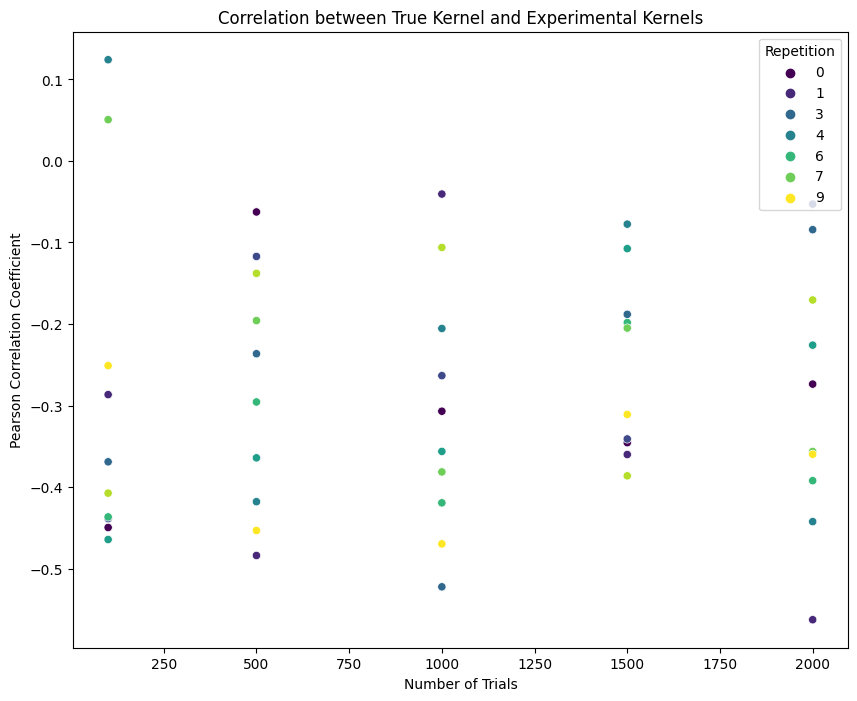

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming that true_kernel_BPF and kernels_ci are DataFrames that look like this:
# true_kernel_BPF: DataFrame with columns ['Segment', 'Time', 'Pitch'] where 'Pitch' contains the true kernel values
# kernels_ci: DataFrame with columns ['repetition', 'num_trials', 'segment', 'kernel_value', 'norm_value'] as shown in your screenshot

# First, we need to ensure that true_kernel_BPF is a DataFrame
# true_kernel_BPF = pd.DataFrame(your_array, columns=['Segment', 'Time', 'Pitch'])
true_kernel_values = true_kernel_BPF['Pitch'].values

# Initialize a list to store the correlation results
correlation_results = []

# Calculate correlation for each unique num_trials and repetition
for num_trials in kernels_ci1['trial_set'].unique():
    for repetition in kernels_ci1['repetition'].unique():
        # Filter the data for the current num_trials and repetition
        filtered_data = kernels_ci1[(kernels_ci1['trial_set'] == num_trials) &
                                   (kernels_ci1['repetition'] == repetition)]
        
        # Ensure that the length of the data matches
        if len(filtered_data) == len(true_kernel_values):
            # Calculate the Pearson correlation coefficient
            correlation = np.corrcoef(true_kernel_values, filtered_data['kernel_value'])[0, 1]
            # Append to the results list
            correlation_results.append({
                'trial_set': num_trials,
                'repetition': repetition,
                'correlation': correlation
            })

# Convert the results to a DataFrame
correlation_df = pd.DataFrame(correlation_results)
print(correlation_df.columns)

# Create the scatter plot
plt.figure(figsize=(10, 8))
scatter_plot = sns.scatterplot(data=correlation_df, x='trial_set', y='correlation', hue='repetition', palette='viridis')

# Add a legend and titles
plt.title('Correlation between True Kernel and Experimental Kernels')
plt.xlabel('Number of Trials')
plt.ylabel('Pearson Correlation Coefficient')
plt.legend(title='Repetition', loc='upper right')

# Show the plot
plt.show()


G:\Utilisateurs\aynaz.adlzarrabi\AppData\Local\Temp\ipykernel_16684\2539550825.py:37: UserWarning: The markers list has more values (4) than needed (1), which may not be intended.
  scatter_plot = sns.scatterplot(


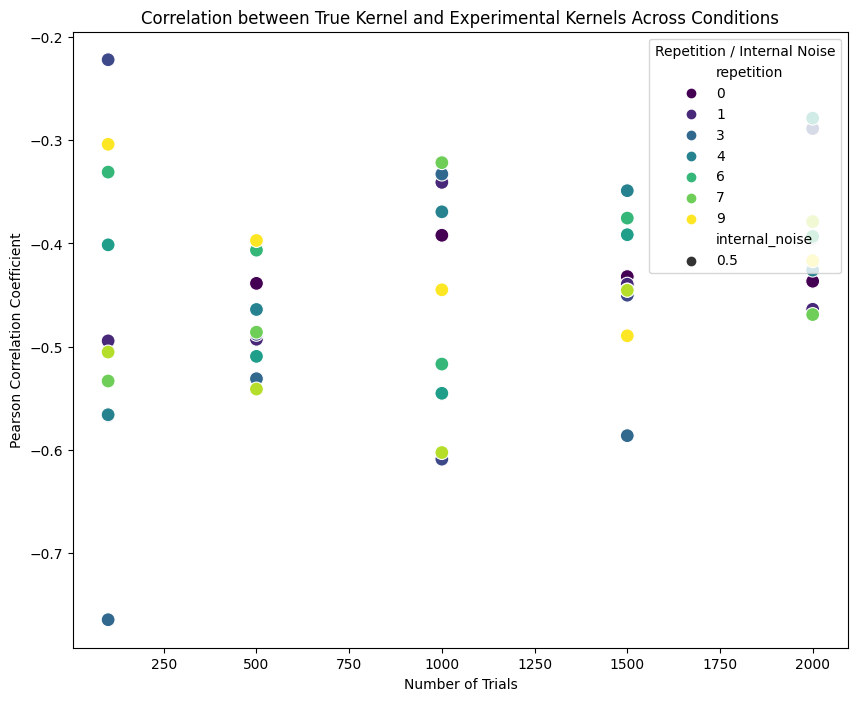

In [94]:
# Assuming that true_kernel_BPF and kernels_ci are DataFrames

# Convert true_kernel_BPF to DataFrame if it's not already
true_kernel_values = true_kernel_BPF.groupby('Segment')['Pitch'].mean().values

# Initialize a list to store the correlation results
correlation_results = []

# Calculate correlation for each unique num_trials, repetition, and internal_noise
for num_trials in kernels_ci1['trial_set'].unique():
    for repetition in kernels_ci1['repetition'].unique():
        for internal_noise in kernels_ci1['internal_noise'].unique():
            # Filter the data for the current num_trials, repetition, and internal_noise
            filtered_data = kernels_ci1[
                (kernels_ci1['trial_set'] == num_trials) &
                (kernels_ci1['repetition'] == repetition) &
                (kernels_ci1['internal_noise'] == internal_noise)
            ]
            
            # Ensure that the length of the data matches
            if len(filtered_data) == len(true_kernel_values):
                # Calculate the Pearson correlation coefficient
                correlation = np.corrcoef(true_kernel_values, filtered_data['kernel_value'])[0, 1]
                # Append to the results list
                correlation_results.append({
                    'num_trials': num_trials,
                    'repetition': repetition,
                    'internal_noise': internal_noise,
                    'correlation': correlation
                })

# Convert the results to a DataFrame
correlation_df = pd.DataFrame(correlation_results)

# Create the scatter plot
plt.figure(figsize=(10, 8))
scatter_plot = sns.scatterplot(
    data=correlation_df,
    x='num_trials',
    y='correlation',
    hue='repetition',
    style='internal_noise',  # Different styles for different internal_noise values
    palette='viridis',
    markers=['o', 's', 'D', '^'], # Different markers for different internal_noise values
    s=100  # Adjust the size of the points
)

# Add a legend and titles
plt.title('Correlation between True Kernel and Experimental Kernels Across Conditions')
plt.xlabel('Number of Trials')
plt.ylabel('Pearson Correlation Coefficient')
plt.legend(title='Repetition / Internal Noise', loc='upper right')

# Show the plot
plt.show()

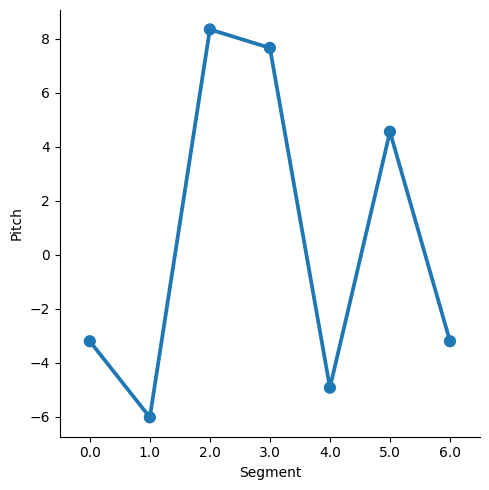

In [93]:
g=sns.catplot(x="Segment", 
                y="Pitch",
                data=true_kernel_BPF,
                kind='point')


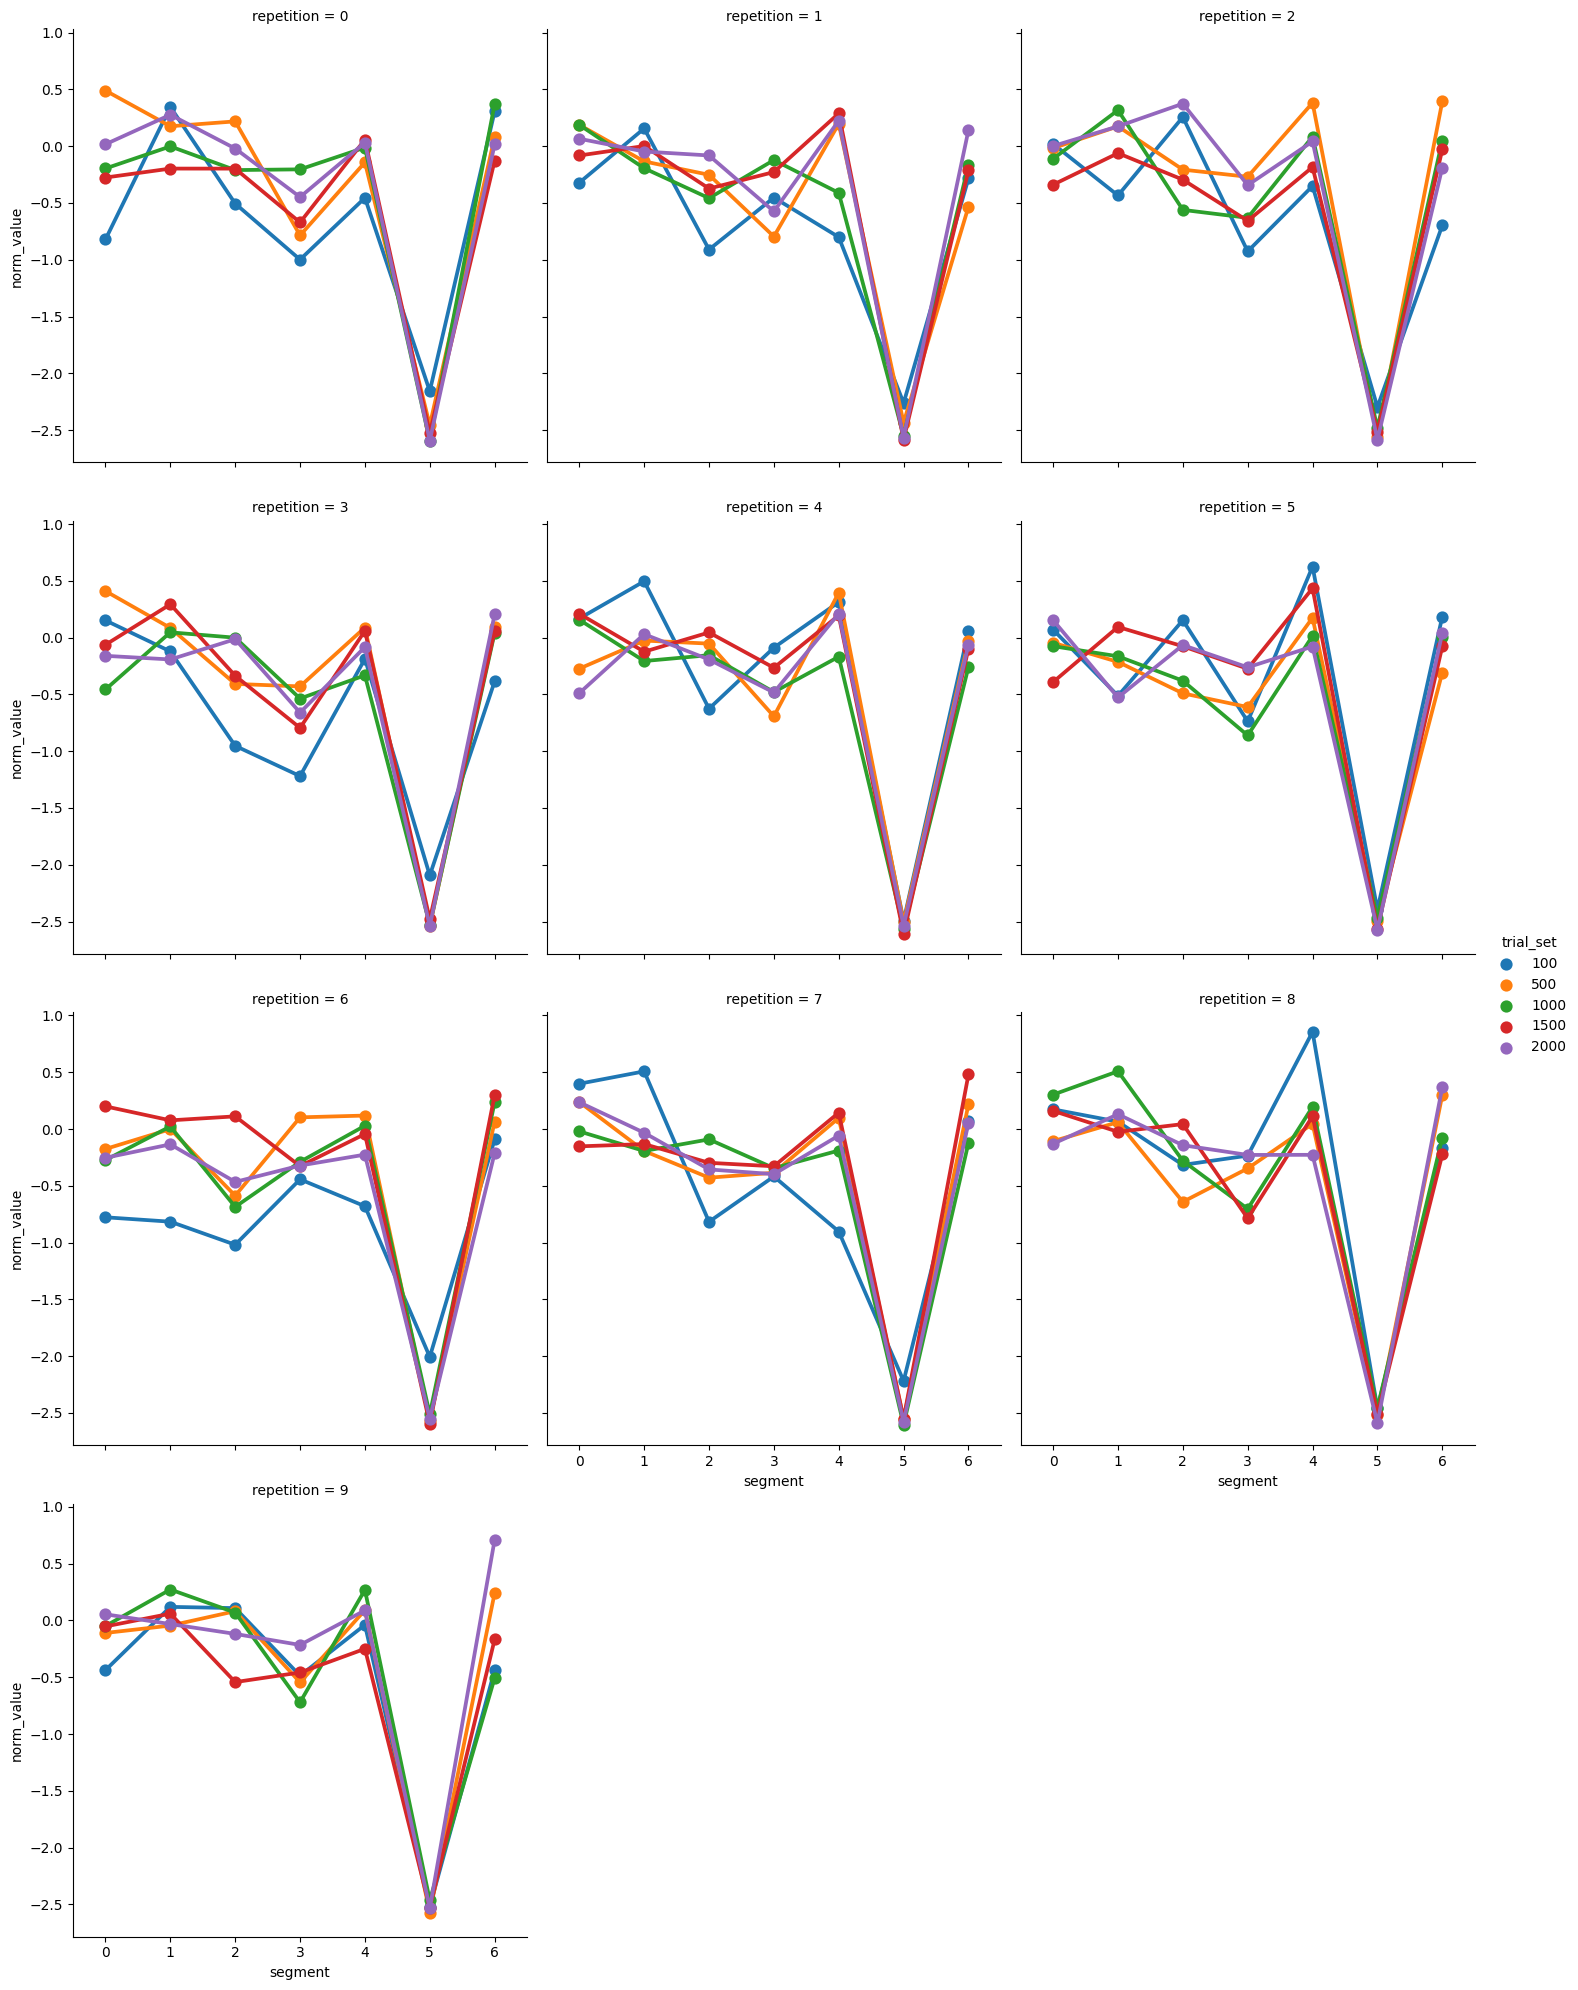

In [90]:
g=sns.catplot(x="segment", 
                y="norm_value",
                col = "repetition",
                hue='trial_set',
                col_wrap=3,
                data=kernels_ci1,
                kind='point')
